
## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Importing the Past Data Datasets

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
crm = pd.read_csv("/Users/mikey/Desktop/ML project /past_data/crm_model.csv")
finance = pd.read_csv("/Users/mikey/Desktop/ML project /past_data/finance_model.csv")
sales = pd.read_csv("/Users/mikey/Desktop/ML project /past_data/sales_model.csv")
print(crm.shape)
print(finance.shape)
print(sales.shape)

(4148, 20)
(4151, 12)
(4153, 24)


# 1. Cleaning & Merging 🧹

## Cleaning Process before merging

In [4]:
# convert columns ID_SALES, Program_Code and Travel_Type to strings
sales['ID_SALES'] = sales['ID_SALES'].astype(str)
sales['Program_Code'] = sales['Program_Code'].astype(str)
sales['Travel_Type'] = sales['Travel_Type'].astype(str)

# remove initial and final parts based on columns Program_Code and Travel_Type
sales["NEW_ID_SALES"] = sales.apply(lambda row: row["ID_SALES"][len(row['Program_Code']):], axis=1)
sales["NEW_ID_SALES"] = sales.apply(lambda row: row["NEW_ID_SALES"][:-len(row['Travel_Type'])] if row['Travel_Type'] != 'N/A' else row['Clean_ID'], axis=1)

print(sales.shape)

# convert columns ID_FINANCE and Special_Pay to strings
finance['ID_FINANCE'] = finance['ID_FINANCE'].astype(str)
finance['Special_Pay'] = finance['Special_Pay'].astype(str)
# remove initial and final parts based on column Special Pay
#finance["NEW_ID_FINANCE"] = finance.apply(lambda row: row['NEW_ID_FINANCE'][len(row['Special_Pay']):] if row['Special_Pay'] != '0' else row['ID_FINANCE'], axis=1)
finance["NEW_ID_FINANCE"] = finance["ID_FINANCE"].str.extract('(\d+)', expand=False)
print(finance.shape)
# convert columns ID_CRM, Poverty_Code and Income_Level to strings
crm['ID_CRM'] = crm['ID_CRM'].astype(str)
crm['Poverty_Code'] = crm['Poverty_Code'].astype(str)
crm['Income_Level'] = crm['Income_Level'].astype(str)
# remove initial and final parts based on columns B and Travel_Type
crm['NEW_ID_CRM'] = crm.apply(lambda row: row['ID_CRM'][len(row['Poverty_Code']):], axis=1)
crm['NEW_ID_CRM'] = crm.apply(lambda row: row['NEW_ID_CRM'][:-len(row['Income_Level'])] if row['Income_Level'] != 'N/A' else row['Clean_ID'], axis=1)

(4153, 25)
(4151, 13)


## Merging Datsets

In [5]:
merge1=pd.merge(sales,crm,left_on="NEW_ID_SALES",right_on="NEW_ID_CRM" )
merge2=pd.merge(merge1,finance,left_on="NEW_ID_SALES",right_on="NEW_ID_FINANCE" )
#merge2.info()
print(merge1.shape)
print(merge2.shape)

(4148, 46)
(4148, 59)


## Cleaning Merged Dataset 

In [6]:
#Drop the column, too many missing values
datacleaning_1=merge2.drop("Early_RPL",axis=1)

#drop all the old ID
datacleaning_1=datacleaning_1.drop("ID_CRM",axis=1)
datacleaning_1=datacleaning_1.drop("ID_FINANCE",axis=1)
datacleaning_1=datacleaning_1.drop("ID_SALES",axis=1)
#transformation in order to don't have the category NA as a missing value and convert 0 to na
datacleaning_1[['Special_Pay']] =datacleaning_1[['Special_Pay']].fillna('Special_Pay_na')
datacleaning_1[['Special_Pay']] =datacleaning_1[['Special_Pay']].replace({'0':'Special_Pay_na'})
#Drop FROM and To
datacleaning_1=datacleaning_1.dropna(subset=["From_Grade", "To_Grade"])
datacleaning_1['From_Grade_To_Grade'] = datacleaning_1['From_Grade'].astype(str) + "-" + datacleaning_1['To_Grade'].astype(str)
datacleaning_1=datacleaning_1.drop("From_Grade",axis=1)
datacleaning_1=datacleaning_1.drop("To_Grade",axis=1)


#drop column date of firstMeeting and LastMeeting
data_best=datacleaning_1.drop('FirstMeeting', axis=1)
data_best=data_best.drop('LastMeeting', axis=1)

In [7]:
#substitute missing data of DifferenceTraveltoFirstMeeting and DifferenceTraveltoLastMeeting with 0 because there was not the meeting 
values = {"DifferenceTraveltoFirstMeeting": 0, "DifferenceTraveltoLastMeeting": 0} 
data_best=data_best.fillna(value=values)

#Transformation of dates in numerical variables

from datetime import datetime

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%m/%d/%Y")
    d2 = datetime.strptime(d2, "%m/%d/%Y")
    return abs((d2 - d1).days)
data_best_2=data_best.dropna(subset=["Initial_System_Date"])
data_best_2["NtripOrganizationDays"] = data_best_2.apply(lambda x: days_between(x["Initial_System_Date"], x["Departure_Date"]), axis=1)

data_best_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3863 entries, 0 to 4147
Data columns (total 53 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Program_Code                    3863 non-null   object 
 1   Group_State                     3863 non-null   object 
 2   Days                            3863 non-null   int64  
 3   Travel_Type                     3863 non-null   object 
 4   Departure_Date                  3863 non-null   object 
 5   Return_Date                     3863 non-null   object 
 6   Latest_RPL                      3840 non-null   object 
 7   Cancelled_Pax                   3863 non-null   int64  
 8   Total_Discount_Pax              3863 non-null   int64  
 9   Initial_System_Date             3863 non-null   object 
 10  SPR_Product_Type                3863 non-null   object 
 11  FPP                             3863 non-null   int64  
 12  Total_Pax                       38

/var/folders/xt/yjtl4jys31763jfkqwb14p1c0000gn/T/ipykernel_62030/2929475020.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_best_2["NtripOrganizationDays"] = data_best_2.apply(lambda x: days_between(x["Initial_System_Date"], x["Departure_Date"]), axis=1)


In [8]:
#Transformation of dates in numerical variables

from datetime import datetime

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%m/%d/%Y")
    d2 = datetime.strptime(d2, "%m/%d/%Y")
    return abs((d2 - d1).days)
data_best_2=data_best.dropna(subset=["Initial_System_Date"])
data_best_2["NtripOrganizationDays"] = data_best_2.apply(lambda x: days_between(x["Initial_System_Date"], x["Departure_Date"]), axis=1)
data_best_3=data_best_2.dropna(subset=["Latest_RPL"])
data_best_3["NDaysLastAdviceToDeparture"] = data_best_3.apply(lambda x: days_between(x["Latest_RPL"], x["Departure_Date"]), axis=1)
data_best_4=data_best_3.dropna(subset=["Deposit_Date"])
data_best_4["NDaysFromDepositeToDeparture"] = data_best_4.apply(lambda x: days_between(x["Deposit_Date"], x["Departure_Date"]), axis=1)
#it is strange that in category month we only have january and february...so we decided to extract the month form the departure date and also to extract the month of the return date
def extract_month(d1):
    d1 = datetime.strptime(d1, "%m/%d/%Y")
    return (d1).month
data_best_4["DepartureMonthCorrect"] = data_best_4.apply(lambda x: extract_month(x["Departure_Date"]), axis=1)
data_best_4["ReturnMonthCorrect"] = data_best_4.apply(lambda x: extract_month(x["Return_Date"]), axis=1)


/var/folders/xt/yjtl4jys31763jfkqwb14p1c0000gn/T/ipykernel_62030/2457485879.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_best_2["NtripOrganizationDays"] = data_best_2.apply(lambda x: days_between(x["Initial_System_Date"], x["Departure_Date"]), axis=1)
/var/folders/xt/yjtl4jys31763jfkqwb14p1c0000gn/T/ipykernel_62030/2457485879.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_best_3["NDaysLastAdviceToDeparture"] = data_best_3.apply(lambda x: days_between(x["Latest_RPL"], x["Departure_Dat

In [9]:
import datetime
# Create a list of the month names
month_names = [datetime.date(1900, i, 1).strftime('%B') for i in range(1, 13)]

# Replace the numbers with the month names
data_best_4["DepartureMonthCorrect"] = data_best_4["DepartureMonthCorrect"] .replace(range(1, 13), month_names)
data_best_4["ReturnMonthCorrect"] = data_best_4["ReturnMonthCorrect"] .replace(range(1, 13), month_names)


#drop NA values
data_best_5=data_best_4.dropna(subset=["MDR_High_Grade", "FPP_to_School_enrollment", "SchoolSizeIndicator", "CRM_Segment"])


#drop NewIDs
byebyeID=["NEW_ID_CRM", "NEW_ID_FINANCE", "NEW_ID_SALES"]
data_best_5=data_best_5.drop(byebyeID, axis=1)


#drop columns with redundant information
todrop2=["Parent_Meeting_Flag", 'SchoolGradeTypeLow', 'SchoolGradeTypeHigh', 'GroupGradeTypeLow', 'GroupGradeTypeHigh']
data_best_5=data_best_5.drop(todrop2, axis=1)

#drop dates
todrop=["Return_Date", "Departure_Date", "Initial_System_Date", "Latest_RPL", "Deposit_Date", "DepartureMonth"]
data_best_final=data_best_5.drop(todrop, axis=1)

data_best_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3704 entries, 0 to 4147
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Program_Code                    3704 non-null   object 
 1   Group_State                     3704 non-null   object 
 2   Days                            3704 non-null   int64  
 3   Travel_Type                     3704 non-null   object 
 4   Cancelled_Pax                   3704 non-null   int64  
 5   Total_Discount_Pax              3704 non-null   int64  
 6   SPR_Product_Type                3704 non-null   object 
 7   FPP                             3704 non-null   int64  
 8   Total_Pax                       3704 non-null   int64  
 9   GroupGradeType                  3704 non-null   object 
 10  MajorProgramCode                3704 non-null   object 
 11  FPP_to_School_enrollment        3704 non-null   object 
 12  Retained                        37

In [10]:
#Correcting datatypes 
df=data_best_final
df['FRP_Take_up_percent_'] = df['FRP_Take_up_percent_'].astype(str)
df['EZ_Pay_Take_Up_Rate'] = df['EZ_Pay_Take_Up_Rate'].astype(str)
df['FPP_to_School_enrollment'] = df['FPP_to_School_enrollment'].astype(str)
df['FPP_to_PAX'] = df['FPP_to_PAX'].astype(str)
df['FRP_Take_up_percent_'] = df['FRP_Take_up_percent_'].str.replace(',', '.').astype(float)
df['EZ_Pay_Take_Up_Rate'] = df['EZ_Pay_Take_Up_Rate'].str.replace(',', '.').astype(float)
df['FPP_to_School_enrollment'] = df['FPP_to_School_enrollment'].str.replace(',', '.').astype(float)
df['FPP_to_PAX'] = df['FPP_to_PAX'].str.replace(',', '.').astype(float)

In [11]:
#'From_Grade' 'To_Grade''MDR_High_Grade' 
df['MDR_High_Grade' ] = df['MDR_High_Grade'].astype(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3704 entries, 0 to 4147
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Program_Code                    3704 non-null   object 
 1   Group_State                     3704 non-null   object 
 2   Days                            3704 non-null   int64  
 3   Travel_Type                     3704 non-null   object 
 4   Cancelled_Pax                   3704 non-null   int64  
 5   Total_Discount_Pax              3704 non-null   int64  
 6   SPR_Product_Type                3704 non-null   object 
 7   FPP                             3704 non-null   int64  
 8   Total_Pax                       3704 non-null   int64  
 9   GroupGradeType                  3704 non-null   object 
 10  MajorProgramCode                3704 non-null   object 
 11  FPP_to_School_enrollment        3704 non-null   float64
 12  Retained                        37

In [12]:
#We replace string 0 with string A because poverty code is A if the value is between 0 and 5.9
df["Poverty_Code"] = df["Poverty_Code"].replace({'0': 'A'})
#We replace string P+number with string P
df["Income_Level"] = df["Income_Level"].replace({'P3': 'P'}, regex=True)
df["Income_Level"] = df["Income_Level"].replace({'P4': 'P'})
df["Income_Level"] = df["Income_Level"].replace({'P1': 'P'})

# 2. Data exploration & Transformation 📈

Retained
0    1450
1    2254
dtype: int64


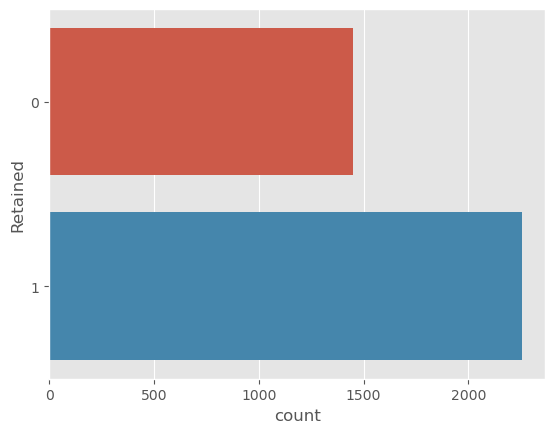

In [13]:
print(df.groupby('Retained').size())
plt.style.use('ggplot')

#Visualize the Retained values
sns.countplot(y=df.Retained ,data=df)
plt.ylabel("Retained")
plt.show()

In [14]:
# Define the columns you want to plot
columns = ['Poverty_Code', 'Region', 'School_Type', 'MDR_Low_Grade','MDR_High_Grade', 'Income_Level', 
           'SchoolGradeType', 'SchoolSizeIndicator', 'Special_Pay','School_Sponsor','Program_Code', 
           'Group_State', 'Travel_Type', 'SPR_Product_Type', 'GroupGradeType', 'MajorProgramCode', 
           'DepartureMonthCorrect','ReturnMonthCorrect','From_Grade', 'To_Grade']
sns.set(style="darkgrid")

ax = sns.countplot(x="Poverty_Code", data=df)

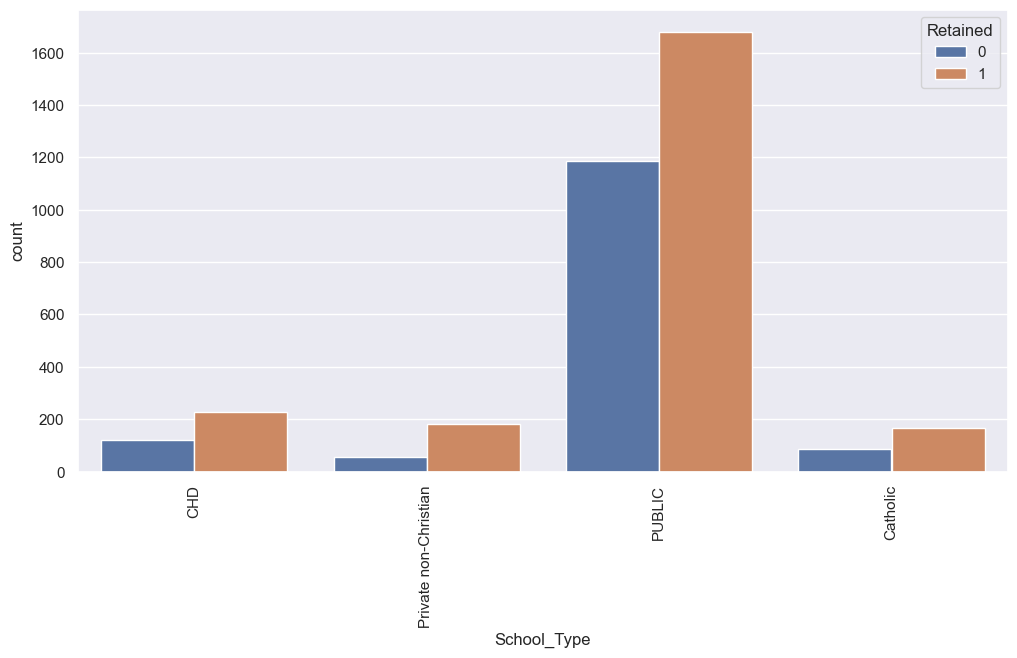

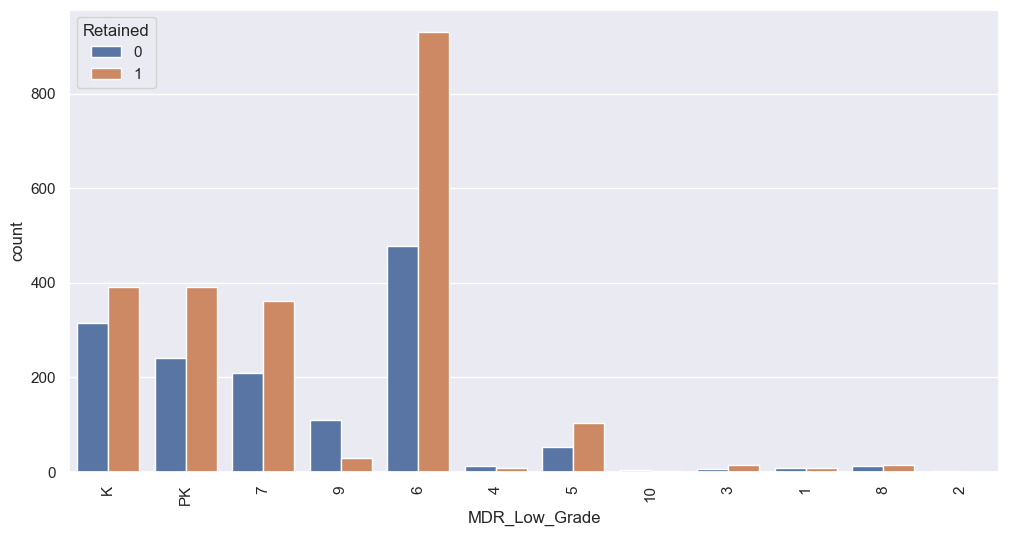

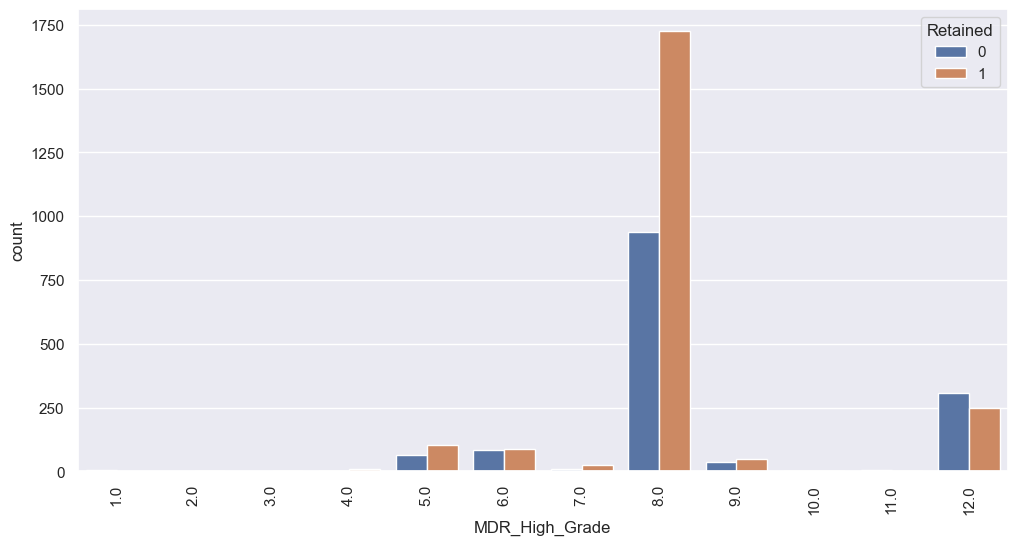

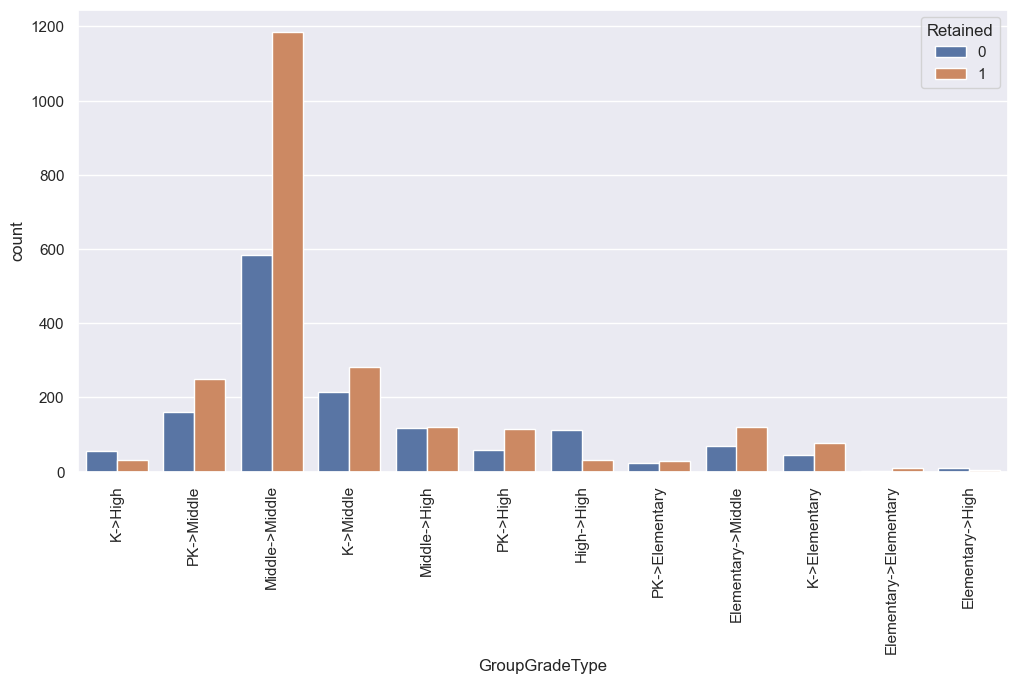

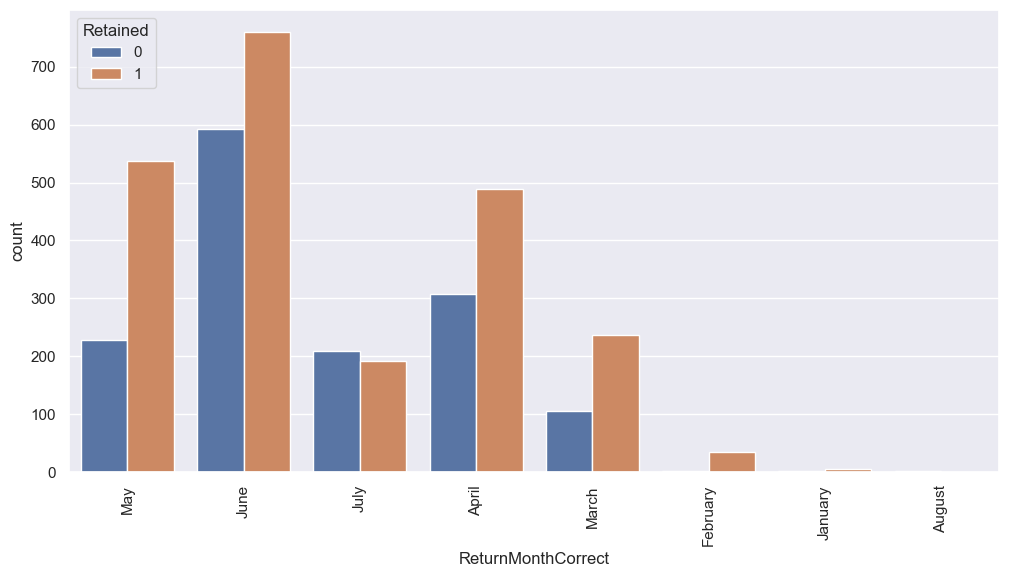

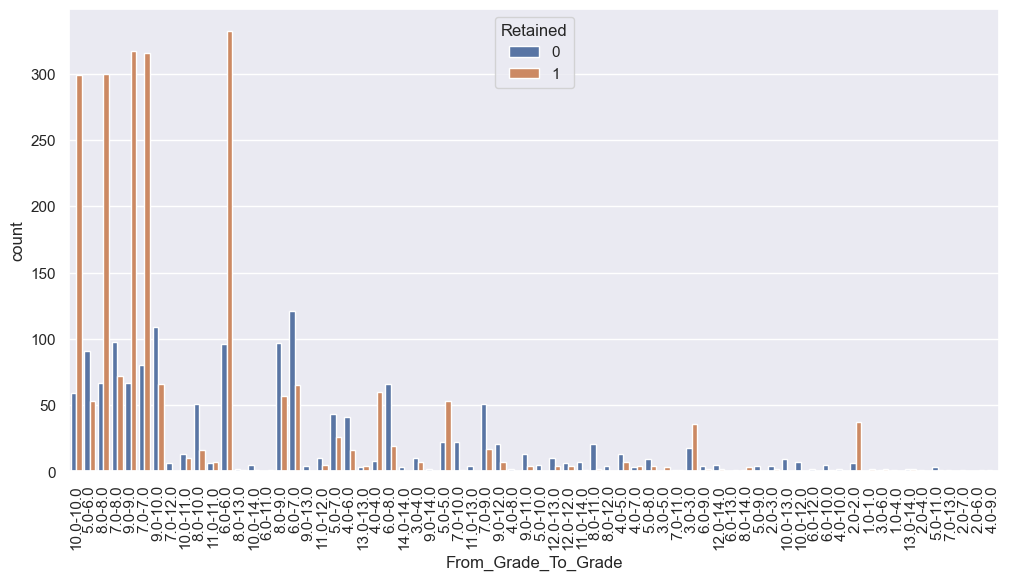

In [15]:
#Visualize the columns to analyze how are their related to Retained  
columns = ['Poverty_Code', 'Region', 'School_Type', 'MDR_Low_Grade','MDR_High_Grade', 'Income_Level', 
           'SchoolGradeType', 'SchoolSizeIndicator', 'Special_Pay','School_Sponsor','Program_Code', 
           'Group_State', 'Travel_Type', 'SPR_Product_Type', 'GroupGradeType', 'MajorProgramCode', 
           'DepartureMonthCorrect','ReturnMonthCorrect','From_Grade_To_Grade']
for col in columns:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax = sns.countplot(x=col, data=df, hue='Retained')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

# OneHotEncoder and more data transformation

In [16]:
from sklearn.preprocessing import OneHotEncoder
#We create the dummies through OneHotEncoder
# Define the columns you want to encode
columns_cat = ['Poverty_Code', 'Region', 'School_Type', 'MDR_Low_Grade','MDR_High_Grade', 'Income_Level', 
           'SchoolGradeType', 'SchoolSizeIndicator', 'Special_Pay','School_Sponsor','Program_Code', 
           'Group_State', 'Travel_Type', 'SPR_Product_Type', 'GroupGradeType', 'MajorProgramCode', 
           'DepartureMonthCorrect','ReturnMonthCorrect','From_Grade_To_Grade']
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(df[columns_cat])  
columns_dummies=encoder.get_feature_names_out()
dummies = encoder.transform(df[columns_cat]).toarray()
dummies = pd.DataFrame(dummies,columns=columns_dummies)


#Save the encoder. We save the encoder into a pickle file so in the future when new data arrives, we can reuse the encoder
import pickle  
pickle.dump(encoder, open('encoder.pkl', 'wb')) 

In [17]:
#Drop Columns
columns = ['Poverty_Code', 'Region', 'School_Type', 'MDR_Low_Grade','MDR_High_Grade', 'Income_Level', 
           'SchoolGradeType', 'SchoolSizeIndicator', 'Special_Pay','School_Sponsor','Program_Code', 
           'Group_State', 'Travel_Type', 'SPR_Product_Type', 'GroupGradeType', 'MajorProgramCode', 
           'DepartureMonthCorrect','ReturnMonthCorrect','From_Grade_To_Grade']
df_num=df.drop(columns=columns)
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3704 entries, 0 to 4147
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Days                            3704 non-null   int64  
 1   Cancelled_Pax                   3704 non-null   int64  
 2   Total_Discount_Pax              3704 non-null   int64  
 3   FPP                             3704 non-null   int64  
 4   Total_Pax                       3704 non-null   int64  
 5   FPP_to_School_enrollment        3704 non-null   float64
 6   Retained                        3704 non-null   int64  
 7   CRM_Segment                     3704 non-null   float64
 8   Total_School_Enrollment         3704 non-null   int64  
 9   SPR_New_Existing                3704 non-null   int64  
 10  NumberOfMeetingswithParents     3704 non-null   int64  
 11  DifferenceTraveltoFirstMeeting  3704 non-null   float64
 12  DifferenceTraveltoLastMeeting   37

In [18]:
#Plot Variables looking for insights in the distribution
X=df_num

X0 = X[X['Retained']==0]
X1 = X[X['Retained']==1]

fig, axes = plt.subplots(ncols=5, nrows=6, figsize=(20,15))
fig.tight_layout()

for i, ax in zip(range(X.columns.size), axes.flat):
    sns.histplot(X0.iloc[:,i], color="blue", element="step", ax=ax,  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="red", element="step", ax=ax,  alpha=0.3)
plt.show()

In [19]:
#Transform some numerical variables
df_num[["Log_Total_School_Enrollment","Log_Cancelled_Pax", "Log_Total_Discount_Pax", "Log_FPP","FPP_to_School_enrollment", 
        "Log_FRP_Active",
        "Log_FRP_Cancelled","Log_EZ_Pay_Take_Up_Rate",'Log_Num_of_Non_FPP_PAX', 'Log_Total_Pax',
        'Log_SPR_Group_Revenue']] = df_num[["Total_School_Enrollment", "Cancelled_Pax", "Total_Discount_Pax",
                                         "FPP","FPP_to_School_enrollment", "FRP_Active","FRP_Cancelled",
                                         "EZ_Pay_Take_Up_Rate",'Num_of_Non_FPP_PAX', 'Total_Pax', 
                                         'SPR_Group_Revenue']].apply(lambda x: np.log(x+1))

df_num=df_num.drop(["Total_School_Enrollment", "Cancelled_Pax", "Total_Discount_Pax",
                                         "FPP","FPP_to_School_enrollment", "FRP_Active","FRP_Cancelled",
                                         "EZ_Pay_Take_Up_Rate",'Num_of_Non_FPP_PAX', 'Total_Pax', 
                                         'SPR_Group_Revenue'], axis=1)


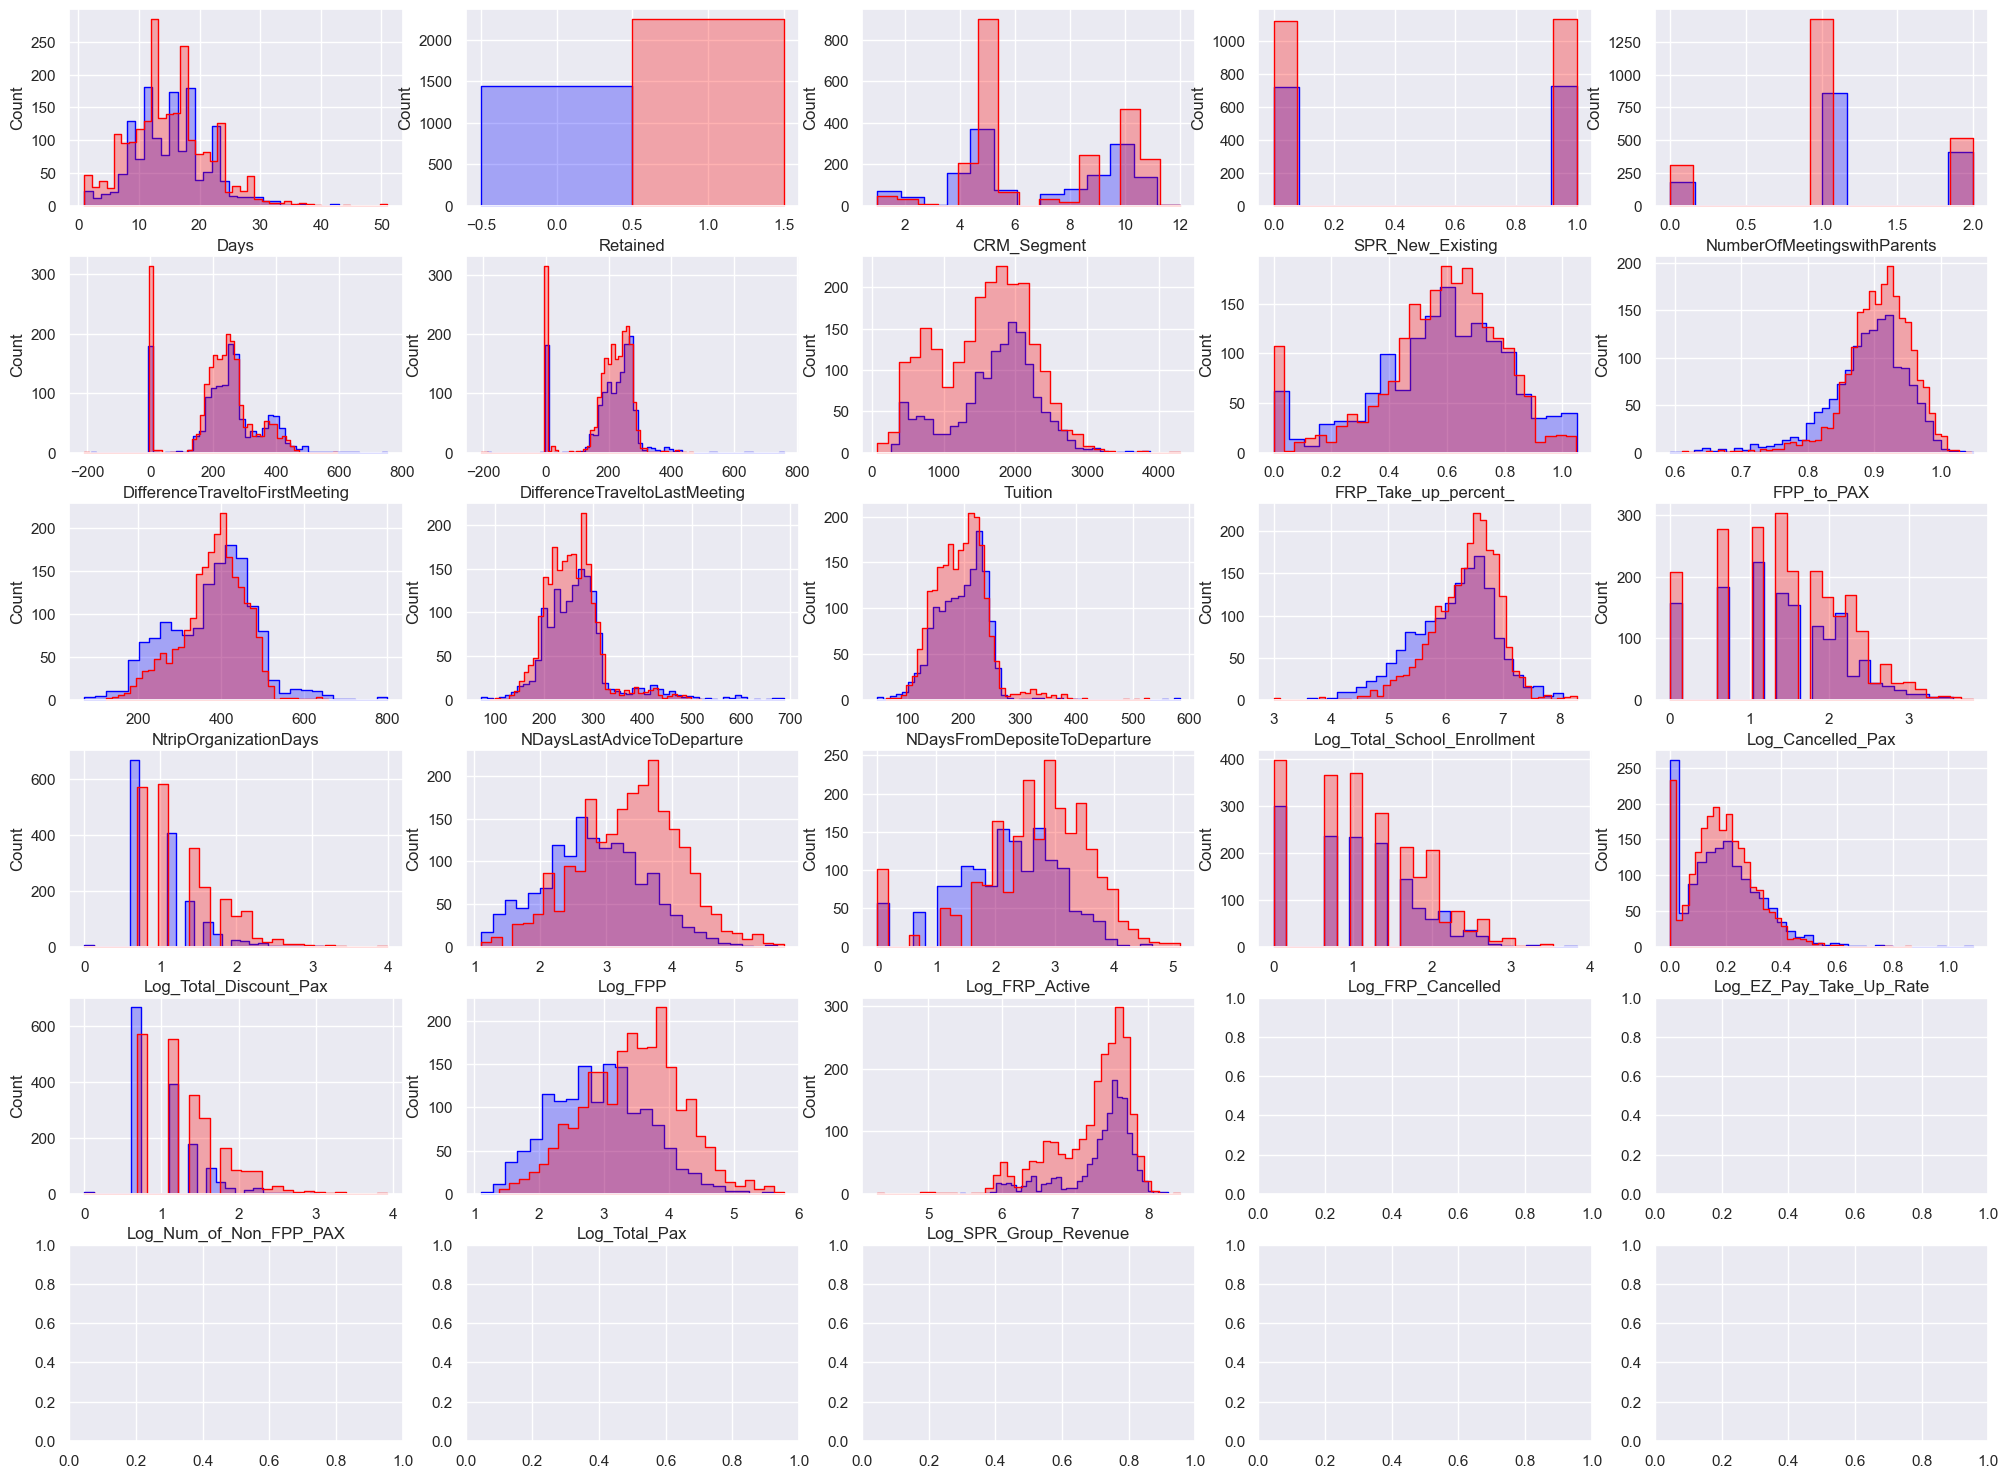

In [20]:
#Plot Variables looking for insights in the new distributions
X=df_num

X0 = X[X['Retained']==0]
X1 = X[X['Retained']==1]

fig, axes = plt.subplots(ncols=5, nrows=6, figsize=(20,15))
fig.tight_layout()

for i, ax in zip(range(X.columns.size), axes.flat):
    sns.histplot(X0.iloc[:,i], color="blue", element="step", ax=ax,  alpha=0.3)
    sns.histplot(X1.iloc[:,i], color="red", element="step", ax=ax,  alpha=0.3)
plt.show()

In [21]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3704 entries, 0 to 4147
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Days                            3704 non-null   int64  
 1   Retained                        3704 non-null   int64  
 2   CRM_Segment                     3704 non-null   float64
 3   SPR_New_Existing                3704 non-null   int64  
 4   NumberOfMeetingswithParents     3704 non-null   int64  
 5   DifferenceTraveltoFirstMeeting  3704 non-null   float64
 6   DifferenceTraveltoLastMeeting   3704 non-null   float64
 7   Tuition                         3704 non-null   int64  
 8   FRP_Take_up_percent_            3704 non-null   float64
 9   FPP_to_PAX                      3704 non-null   float64
 10  NtripOrganizationDays           3704 non-null   int64  
 11  NDaysLastAdviceToDeparture      3704 non-null   int64  
 12  NDaysFromDepositeToDeparture    37

In [22]:
y=df_num["Retained"]
#df_num.info()
y.info()

<class 'pandas.core.series.Series'>
Int64Index: 3704 entries, 0 to 4147
Series name: Retained
Non-Null Count  Dtype
--------------  -----
3704 non-null   int64
dtypes: int64(1)
memory usage: 57.9 KB


In [23]:
df_num=df_num.drop('Retained', axis=1)

In [24]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler().fit(df_num)
# fit and transform the data
df_num_scaled = pd.DataFrame(scaler.transform(df_num))
df_num_scaled.columns = df_num.columns

df_num_scaled.head()

# Save the scaler
import pickle
pickle.dump(scaler, open('scaler.pkl', 'wb'))

<AxesSubplot:>

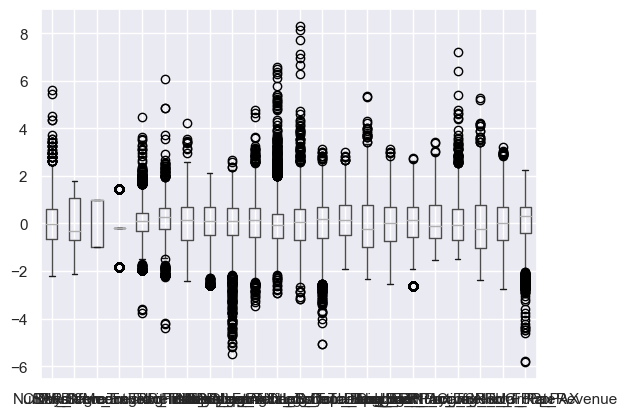

In [25]:
df_num_scaled.boxplot()

In [26]:
# Save the scaler. We need to save the scaler in order to apply it to the future data
import pickle
pickle.dump(scaler, open('scaler.pkl', 'wb')) 

In [27]:
#Getting Dummies
df_conc=pd.concat([df_num_scaled, dummies], axis=1)
df_conc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3704 entries, 0 to 3703
Columns: 279 entries, Days to From_Grade_To_Grade_9.0-9.0
dtypes: float64(279)
memory usage: 7.9 MB


In [28]:
#Checking if we have the correct columns 
X=df_conc
X.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3704 entries, 0 to 3703
Data columns (total 279 columns):
 #    Column                                  Dtype  
---   ------                                  -----  
 0    Days                                    float64
 1    CRM_Segment                             float64
 2    SPR_New_Existing                        float64
 3    NumberOfMeetingswithParents             float64
 4    DifferenceTraveltoFirstMeeting          float64
 5    DifferenceTraveltoLastMeeting           float64
 6    Tuition                                 float64
 7    FRP_Take_up_percent_                    float64
 8    FPP_to_PAX                              float64
 9    NtripOrganizationDays                   float64
 10   NDaysLastAdviceToDeparture              float64
 11   NDaysFromDepositeToDeparture            float64
 12   Log_Total_School_Enrollment             float64
 13   Log_Cancelled_Pax                       float64
 14   Log_Total_Discount_Pax

## Splitting into trainning and test

In [29]:
from sklearn.model_selection import train_test_split

#SPLIT DATA INTO TRAIN AND TEST SET
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size =0.30, #by default is 75%-25%
                                                    #shuffle is set True by default,
                                                    stratify=y,
                                                    random_state= 123
                                                    ) 

print(X_train.shape,X_test.shape)

(2592, 279) (1112, 279)


# 3. MODELS 🧰

## 3.1 K-Neighbours

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
classifier = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(1,30), 'weights':['uniform', 'distance'], 'metric':['cosine', 'euclidean']}   #'manhattan'

gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'precision', verbose=90, n_jobs=-1)

In [31]:
#train your classifier
gs = gs.fit(X_train, y_train)

Fitting 3 folds for each of 116 candidates, totalling 348 fits


/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer b

/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer b

/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer b

/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer b

/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer b

/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer b

/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer b

/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer b

/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer b

/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer b

/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer b

In [32]:
#summarize the results of your gridsearch
print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))

means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean %f Std (%f) with: %r" % (mean, stdev, param))

Best score: 0.848950 using {'metric': 'cosine', 'n_neighbors': 2, 'weights': 'uniform'}
Mean 0.824454 Std (0.007411) with: {'metric': 'cosine', 'n_neighbors': 1, 'weights': 'uniform'}
Mean 0.824454 Std (0.007411) with: {'metric': 'cosine', 'n_neighbors': 1, 'weights': 'distance'}
Mean 0.848950 Std (0.011161) with: {'metric': 'cosine', 'n_neighbors': 2, 'weights': 'uniform'}
Mean 0.824454 Std (0.007411) with: {'metric': 'cosine', 'n_neighbors': 2, 'weights': 'distance'}
Mean 0.741257 Std (0.003728) with: {'metric': 'cosine', 'n_neighbors': 3, 'weights': 'uniform'}
Mean 0.810500 Std (0.005946) with: {'metric': 'cosine', 'n_neighbors': 3, 'weights': 'distance'}
Mean 0.781596 Std (0.009792) with: {'metric': 'cosine', 'n_neighbors': 4, 'weights': 'uniform'}
Mean 0.805721 Std (0.007473) with: {'metric': 'cosine', 'n_neighbors': 4, 'weights': 'distance'}
Mean 0.730605 Std (0.009775) with: {'metric': 'cosine', 'n_neighbors': 5, 'weights': 'uniform'}
Mean 0.791289 Std (0.011106) with: {'metric'

In [33]:
#Evaluate predictions Training set

from sklearn import metrics
best_model = gs.best_estimator_

y_pred_train = best_model.predict(X_train)
y_pred = best_model.predict(X_test)

print('***RESULTS ON TRAIN SET***')
print("precision: ", metrics.precision_score(y_train, y_pred_train)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_train, y_pred_train)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_train, y_pred_train)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_train, y_pred_train)) # (tp+tn)/m

#Evaluate predictions Test set
from sklearn import metrics 

print('***RESULTS ON TEST SET***')
print("precision: ", metrics.precision_score(y_test, y_pred)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_test, y_pred)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_test, y_pred)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_test, y_pred)) # (tp+tn)/m

***RESULTS ON TRAIN SET***
precision:  1.0
recall:  0.8896639188332276
f1_score:  0.9416107382550335
accuracy:  0.9328703703703703
***RESULTS ON TEST SET***
precision:  0.8863198458574181
recall:  0.6794682422451994
f1_score:  0.7692307692307692
accuracy:  0.7517985611510791


/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer b

In [34]:
#Getting Confsion Matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[376  59]
 [217 460]]


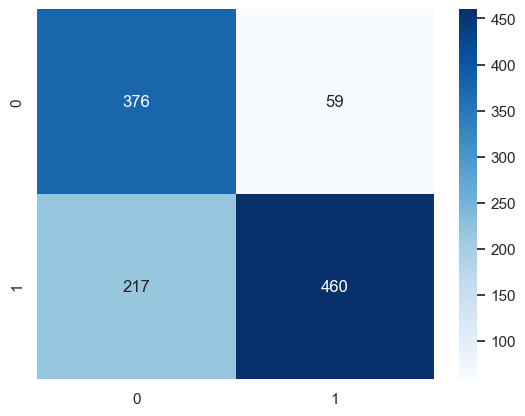

In [35]:
# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues");

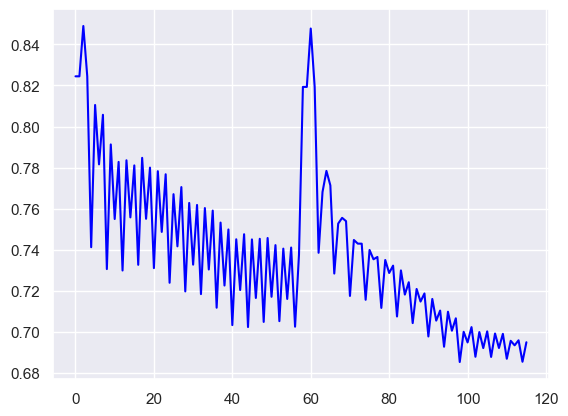

0.8489501610848514


In [36]:
#Plotting the grid search results


plt.plot (means, color='blue', alpha=1.00)
plt.show()

print(gs.best_score_)

In [37]:
#KNN superOverfitted!!! even if the model is not really a complicated model (just 2 neighbours!)

## 3.2 Logistic Regression

In [38]:
#Define classifier and parameters gridsearch
from sklearn.linear_model import LogisticRegression
import numpy as np

classifier = LogisticRegression()
parameters = {"C":[1e-2,1e-1,1,5],"penalty":['l2'] , "max_iter":[500,10000]}

In [39]:
#Define gridsearch
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'accuracy', verbose=50, n_jobs=-1, refit=True)

In [40]:
#Training the classifier
gs = gs.fit(X_train, y_train)
best_model = gs.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [41]:
#summarize results of gridsearch
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.743056 using {'C': 5, 'max_iter': 500, 'penalty': 'l2'}
0.714120 (0.017502) with: {'C': 0.01, 'max_iter': 500, 'penalty': 'l2'}
0.714120 (0.017502) with: {'C': 0.01, 'max_iter': 10000, 'penalty': 'l2'}
0.739198 (0.015595) with: {'C': 0.1, 'max_iter': 500, 'penalty': 'l2'}
0.739198 (0.015595) with: {'C': 0.1, 'max_iter': 10000, 'penalty': 'l2'}
0.742670 (0.007093) with: {'C': 1, 'max_iter': 500, 'penalty': 'l2'}
0.742670 (0.007093) with: {'C': 1, 'max_iter': 10000, 'penalty': 'l2'}
0.743056 (0.008661) with: {'C': 5, 'max_iter': 500, 'penalty': 'l2'}
0.743056 (0.008661) with: {'C': 5, 'max_iter': 10000, 'penalty': 'l2'}


In [42]:
#Evaluate predictions training set
y_pred_train = best_model.predict(X_train)
y_pred = best_model.predict(X_test)

print('***RESULTS ON TRAIN SET***')
print("precision: ", metrics.precision_score(y_train, y_pred_train)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_train, y_pred_train)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_train, y_pred_train)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_train, y_pred_train)) # (tp+tn)/m

#Evaluate predictions test set
from sklearn import metrics 

print('***RESULTS ON TEST SET***')
print("precision: ", metrics.precision_score(y_test, y_pred)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_test, y_pred)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_test, y_pred)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_test, y_pred)) # (tp+tn)/m

***RESULTS ON TRAIN SET***
precision:  0.81725584182145
recall:  0.8649334178820546
f1_score:  0.840418977202711
accuracy:  0.8001543209876543
***RESULTS ON TEST SET***
precision:  0.7846364883401921
recall:  0.844903988183161
f1_score:  0.813655761024182
accuracy:  0.7643884892086331


In [43]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[278 157]
 [105 572]]


In [44]:
# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues"); #annot=True to annotate cells fmt: format

In [45]:
#top contender for now! It is not overfitted

## 3.3 Decision Tree Classifier

In [46]:
#Define classifier and parameters gridsearch
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 
              'max_depth': [2,3,4],
              'min_samples_split': [2,3,4,5],
              'min_samples_leaf': [2,3,4,5]}

In [47]:
#Define gridsearch

from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'precision', verbose=10, n_jobs=-1)

In [48]:
gs = gs.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


In [49]:
#summarize results of gridsearch
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']


for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.701427 using {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 3}
0.681049 (0.046495) with: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.681049 (0.046495) with: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 3}
0.681049 (0.046495) with: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 4}
0.681049 (0.046495) with: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.681049 (0.046495) with: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2}
0.681049 (0.046495) with: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 3}
0.681049 (0.046495) with: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 4}
0.681049 (0.046495) with: {'criterion': 'entropy', 'max_depth': 2

In [50]:
#test on the test set
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)

y_pred_train = best_model.predict(X_train)

In [51]:
#Evaluate predictions on training set
print('***RESULTS ON TRAIN SET***')
print("precision: ", metrics.precision_score(y_train, y_pred_train)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_train, y_pred_train)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_train, y_pred_train)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_train, y_pred_train)) # (tp+tn)/m

#Evaluate predictions on test set
from sklearn import metrics 

print('***RESULTS ON TEST SET***')
print("precision: ", metrics.precision_score(y_test, y_pred)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_test, y_pred)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_test, y_pred)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_test, y_pred)) # (tp+tn)/m

***RESULTS ON TRAIN SET***
precision:  0.7222535211267606
recall:  0.8129359543436906
f1_score:  0.7649164677804297
accuracy:  0.6959876543209876
***RESULTS ON TEST SET***
precision:  0.7029831387808041
recall:  0.8005908419497785
f1_score:  0.7486187845303868
accuracy:  0.6726618705035972


In [52]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[206 229]
 [135 542]]


In [53]:
# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues", cbar=False);

In [54]:
from sklearn import metrics
model = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=2, min_samples_split=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])


plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

AUC: 0.70


In [55]:
from sklearn import tree
r = tree.export_text(model,feature_names=X_test.columns.tolist())
print(r)

|--- Log_Total_Pax <= 0.03
|   |--- SchoolGradeType_High->High <= 0.50
|   |   |--- Log_Total_Pax <= -0.74
|   |   |   |--- class: 0
|   |   |--- Log_Total_Pax >  -0.74
|   |   |   |--- class: 1
|   |--- SchoolGradeType_High->High >  0.50
|   |   |--- Program_Code_SG <= 0.50
|   |   |   |--- class: 0
|   |   |--- Program_Code_SG >  0.50
|   |   |   |--- class: 1
|--- Log_Total_Pax >  0.03
|   |--- NtripOrganizationDays <= -1.47
|   |   |--- Log_FRP_Active <= 0.77
|   |   |   |--- class: 0
|   |   |--- Log_FRP_Active >  0.77
|   |   |   |--- class: 1
|   |--- NtripOrganizationDays >  -1.47
|   |   |--- NtripOrganizationDays <= 1.37
|   |   |   |--- class: 1
|   |   |--- NtripOrganizationDays >  1.37
|   |   |   |--- class: 0



In [56]:
#not on par with the top contender

## 3.4 Random Forest

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

classifier= RandomForestClassifier()
parameters = {'n_estimators' : [18,19,20,21,22,23],
    'criterion' : ['entropy','gini' ], #'gini'
             'max_depth' : [2,3,4], 
             'min_samples_split' : [3,4,5],
              'min_samples_leaf' : [3,4,5]
             }

gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'accuracy', verbose=10, n_jobs=-1, refit=True)  #'precision'

gs.fit(X_train,y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV 2/3; 2/116] START metric=cosine, n_neighbors=1, weights=distance............
[CV 2/3; 2/116] END metric=cosine, n_neighbors=1, weights=distance;, score=0.819 total time=   0.1s
[CV 1/3; 4/116] START metric=cosine, n_neighbors=2, weights=distance............
[CV 1/3; 4/116] END metric=cosine, n_neighbors=2, weights=distance;, score=0.835 total time=   0.1s
[CV 1/3; 7/116] START metric=cosine, n_neighbors=4, weights=uniform.............
[CV 1/3; 7/116] END metric=cosine, n_neighbors=4, weights=uniform;, score=0.784 total time=   0.2s
[CV 2/3; 10/116] START metric=cosine, n_neighbors=5, weights=distance...........
[CV 2/3; 10/116] END metric=cosine, n_neighbors=5, weights=distance;, score=0.776 total time=   0.1s
[CV 1/3; 13/116] START metric=cosine, n_neighbors=7, weights=uniform............
[CV 1/3; 13/116] END metric=cosine, n_neighbors=7, weights=uniform;, score=0.741 total time=   0.1s
[CV 3/3; 15/116] START metric=co

[CV 3/3; 2/116] START metric=cosine, n_neighbors=1, weights=distance............
[CV 3/3; 2/116] END metric=cosine, n_neighbors=1, weights=distance;, score=0.819 total time=   0.1s
[CV 3/3; 3/116] START metric=cosine, n_neighbors=2, weights=uniform.............
[CV 3/3; 3/116] END metric=cosine, n_neighbors=2, weights=uniform;, score=0.865 total time=   0.1s
[CV 2/3; 7/116] START metric=cosine, n_neighbors=4, weights=uniform.............
[CV 2/3; 7/116] END metric=cosine, n_neighbors=4, weights=uniform;, score=0.769 total time=   0.1s
[CV 1/3; 10/116] START metric=cosine, n_neighbors=5, weights=distance...........
[CV 1/3; 10/116] END metric=cosine, n_neighbors=5, weights=distance;, score=0.799 total time=   0.1s
[CV 2/3; 13/116] START metric=cosine, n_neighbors=7, weights=uniform............
[CV 2/3; 13/116] END metric=cosine, n_neighbors=7, weights=uniform;, score=0.715 total time=   0.1s
[CV 2/3; 15/116] START metric=cosine, n_neighbors=8, weights=uniform............
[CV 2/3; 15/116

[CV 2/3; 89/96] END criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=2;, score=0.700 total time=   0.0s
[CV 1/3; 92/96] START criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=5
[CV 1/3; 92/96] END criterion=gini, max_depth=4, min_samples_leaf=4, min_samples_split=5;, score=0.708 total time=   0.0s
[CV 3/3; 94/96] START criterion=gini, max_depth=4, min_samples_leaf=5, min_samples_split=3
[CV 3/3; 94/96] END criterion=gini, max_depth=4, min_samples_leaf=5, min_samples_split=3;, score=0.671 total time=   0.0s
[CV 2/3; 2/324] START criterion=entropy, max_depth=2, min_samples_leaf=3, min_samples_split=3, n_estimators=19
[CV 2/3; 2/324] END criterion=entropy, max_depth=2, min_samples_leaf=3, min_samples_split=3, n_estimators=19;, score=0.638 total time=   0.1s
[CV 3/3; 4/324] START criterion=entropy, max_depth=2, min_samples_leaf=3, min_samples_split=3, n_estimators=21
[CV 3/3; 4/324] END criterion=entropy, max_depth=2, min_samples_leaf=3, min_samples_spli

[CV 1/3; 9/324] END criterion=entropy, max_depth=2, min_samples_leaf=3, min_samples_split=4, n_estimators=20;, score=0.645 total time=   0.1s
[CV 2/3; 9/324] START criterion=entropy, max_depth=2, min_samples_leaf=3, min_samples_split=4, n_estimators=20
[CV 2/3; 9/324] END criterion=entropy, max_depth=2, min_samples_leaf=3, min_samples_split=4, n_estimators=20;, score=0.648 total time=   0.0s
[CV 3/3; 13/324] START criterion=entropy, max_depth=2, min_samples_leaf=3, min_samples_split=5, n_estimators=18
[CV 3/3; 13/324] END criterion=entropy, max_depth=2, min_samples_leaf=3, min_samples_split=5, n_estimators=18;, score=0.617 total time=   0.0s
[CV 1/3; 14/324] START criterion=entropy, max_depth=2, min_samples_leaf=3, min_samples_split=5, n_estimators=19
[CV 1/3; 14/324] END criterion=entropy, max_depth=2, min_samples_leaf=3, min_samples_split=5, n_estimators=19;, score=0.618 total time=   0.0s
[CV 3/3; 17/324] START criterion=entropy, max_depth=2, min_samples_leaf=3, min_samples_split=5,

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [2, 3, 4], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [3, 4, 5],
                         'n_estimators': [18, 19, 20, 21, 22, 23]},
             scoring='accuracy', verbose=10)

In [58]:
#summarize results of gridsearch
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.699074 using {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 23}
0.640432 (0.007697) with: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 18}
0.636960 (0.000546) with: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 19}
0.634259 (0.005902) with: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 20}
0.632330 (0.001444) with: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 21}
0.647377 (0.005537) with: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 22}
0.639660 (0.010953) with: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 23}
0.632330 (0.010953) with: {'criterion':

In [59]:
#Test on the test set
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)

In [60]:
#Generate a report that summarizes the performance of the model
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.30      0.44       435
           1       0.68      0.95      0.79       677

    accuracy                           0.69      1112
   macro avg       0.73      0.62      0.61      1112
weighted avg       0.72      0.69      0.65      1112



In [61]:
#Evaluate predictions training set
y_pred_train = best_model.predict(X_train)

print('***RESULTS ON TRAIN SET***')
print("precision: ", metrics.precision_score(y_train, y_pred_train)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_train, y_pred_train)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_train, y_pred_train)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_train, y_pred_train)) # (tp+tn)/m

#Evaluate predictions test set
from sklearn import metrics 

print('***RESULTS ON TEST SET***')
print("precision: ", metrics.precision_score(y_test, y_pred)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_test, y_pred)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_test, y_pred)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_test, y_pred)) # (tp+tn)/m

***RESULTS ON TRAIN SET***
precision:  0.6873008648156577
recall:  0.9575142675967026
f1_score:  0.8002119766825648
accuracy:  0.7091049382716049
***RESULTS ON TEST SET***
precision:  0.6783068783068783
recall:  0.946824224519941
f1_score:  0.7903822441430335
accuracy:  0.6942446043165468


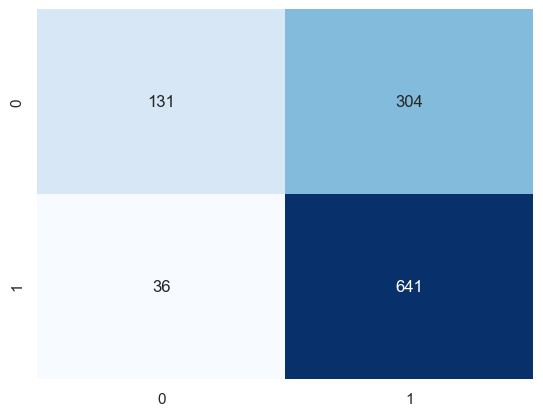

In [62]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues", cbar=False);

In [63]:
#Train the model and get the prediction
from sklearn.ensemble import RandomForestClassifier

rand_forest = RandomForestClassifier(n_estimators=18, criterion='gini', max_depth=3, min_samples_split=5, min_samples_leaf=3)
rand_forest.fit(X_train, y_train)

y_pred = rand_forest.predict(X_test)

In [64]:
# ROC curve

from sklearn import metrics

y_probs = rand_forest.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

AUC: 0.75


In [65]:
#it is not working well

## 3.5 Adaboost

In [66]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics


## from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV

classifier= AdaBoostClassifier()
parameters = {'n_estimators' : [40, 50, 60],
    'learning_rate' : [0.01, 0.1, 1, 10]} #0.0001, 

gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'precision', verbose=10, n_jobs=-1, refit=True)

gs.fit(X_train,y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GridSearchCV(cv=3, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1, 10],
                         'n_estimators': [40, 50, 60]},
             scoring='precision', verbose=10)

In [67]:
#summarize results of gridsearch
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.760113 using {'learning_rate': 1, 'n_estimators': 60}
0.714893 (0.039346) with: {'learning_rate': 0.01, 'n_estimators': 40}
0.694369 (0.028111) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.694369 (0.028111) with: {'learning_rate': 0.01, 'n_estimators': 60}
0.678730 (0.007170) with: {'learning_rate': 0.1, 'n_estimators': 40}
0.691144 (0.014189) with: {'learning_rate': 0.1, 'n_estimators': 50}
0.695299 (0.012427) with: {'learning_rate': 0.1, 'n_estimators': 60}
0.748619 (0.016349) with: {'learning_rate': 1, 'n_estimators': 40}
0.750984 (0.017268) with: {'learning_rate': 1, 'n_estimators': 50}
0.760113 (0.016016) with: {'learning_rate': 1, 'n_estimators': 60}
0.329150 (0.232745) with: {'learning_rate': 10, 'n_estimators': 40}
0.329150 (0.232745) with: {'learning_rate': 10, 'n_estimators': 50}
0.329150 (0.232745) with: {'learning_rate': 10, 'n_estimators': 60}


In [68]:
#Evaluate predictions training set 
y_pred_train = best_model.predict(X_train)

print('***RESULTS ON TRAIN SET***')
print("precision: ", metrics.precision_score(y_train, y_pred_train)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_train, y_pred_train)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_train, y_pred_train)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_train, y_pred_train)) # (tp+tn)/m

#Evaluate predictions test set
from sklearn import metrics 

print('***RESULTS ON TEST SET***')
print("precision: ", metrics.precision_score(y_test, y_pred)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_test, y_pred)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_test, y_pred)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_test, y_pred)) # (tp+tn)/m

***RESULTS ON TRAIN SET***
precision:  0.6873008648156577
recall:  0.9575142675967026
f1_score:  0.8002119766825648
accuracy:  0.7091049382716049
***RESULTS ON TEST SET***
precision:  0.6639004149377593
recall:  0.9453471196454948
f1_score:  0.7800121876904327
accuracy:  0.6753597122302158


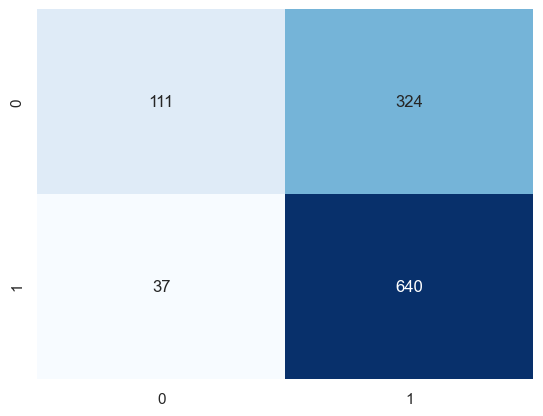

In [69]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues", cbar=False);

In [70]:
#it is not working well

## 3.6 SUPPORT VECTOR MACHINE

In [71]:
#Define classifier and paramaters grid
from sklearn.svm import SVC

classifier = SVC()
parameters = {"kernel":['linear','polinomial'], "C":[1,5],"gamma":[1], "degree":[2,3,4]}

In [72]:
#Define gridsearch
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'accuracy', verbose=50, n_jobs=-1, refit=True)

In [73]:
#training the classifier
gs = gs.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 315, in _dense_fit
    )

In [74]:
#summarize results of gridsearch
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.746142 using {'C': 5, 'degree': 2, 'gamma': 1, 'kernel': 'linear'}
0.745756 (0.012830) with: {'C': 1, 'degree': 2, 'gamma': 1, 'kernel': 'linear'}
nan (nan) with: {'C': 1, 'degree': 2, 'gamma': 1, 'kernel': 'polinomial'}
0.745756 (0.012830) with: {'C': 1, 'degree': 3, 'gamma': 1, 'kernel': 'linear'}
nan (nan) with: {'C': 1, 'degree': 3, 'gamma': 1, 'kernel': 'polinomial'}
0.745756 (0.012830) with: {'C': 1, 'degree': 4, 'gamma': 1, 'kernel': 'linear'}
nan (nan) with: {'C': 1, 'degree': 4, 'gamma': 1, 'kernel': 'polinomial'}
0.746142 (0.004466) with: {'C': 5, 'degree': 2, 'gamma': 1, 'kernel': 'linear'}
nan (nan) with: {'C': 5, 'degree': 2, 'gamma': 1, 'kernel': 'polinomial'}
0.746142 (0.004466) with: {'C': 5, 'degree': 3, 'gamma': 1, 'kernel': 'linear'}
nan (nan) with: {'C': 5, 'degree': 3, 'gamma': 1, 'kernel': 'polinomial'}
0.746142 (0.004466) with: {'C': 5, 'degree': 4, 'gamma': 1, 'kernel': 'linear'}
nan (nan) with: {'C': 5, 'degree': 4, 'gamma

In [75]:
#Test on the test set 
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)

y_pred_train = best_model.predict(X_train)

In [76]:
#Evaluate predictions training set
y_pred_train = best_model.predict(X_train)

print('***RESULTS ON TRAIN SET***')
print("precision: ", metrics.precision_score(y_train, y_pred_train)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_train, y_pred_train)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_train, y_pred_train)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_train, y_pred_train)) # (tp+tn)/m

#Evaluate predictions test set
from sklearn import metrics 

print('***RESULTS ON TEST SET***')
print("precision: ", metrics.precision_score(y_test, y_pred)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_test, y_pred)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_test, y_pred)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_test, y_pred)) # (tp+tn)/m

***RESULTS ON TRAIN SET***
precision:  0.8232784887263863
recall:  0.8566899175649968
f1_score:  0.8396519577377253
accuracy:  0.8009259259259259
***RESULTS ON TEST SET***
precision:  0.7846153846153846
recall:  0.8286558345642541
f1_score:  0.8060344827586208
accuracy:  0.7571942446043165


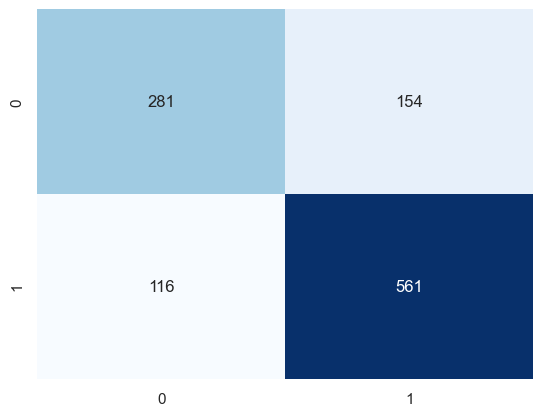

In [77]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues", cbar=False);

In [78]:
#save the model
SupportVC = SVC(C=5, degree=2, kernel='linear', gamma= 1)
SupportVC.fit(X,y)
import pickle
pickle.dump(SupportVC, open('SupportVC_model.pkl', 'wb'))

In [79]:
### It is a contender!!!!

## 3.7 Naive Bayes

In [80]:
from sklearn.naive_bayes import GaussianNB #or alternative NB implementations

model = GaussianNB()

model.fit(X_train, y_train)
y_pred=model.predict(X_test)

y_pred_train=model.predict(X_train)

In [81]:
#Evaluate prediction on training set 
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

print('***RESULTS ON TRAIN SET***')
print("precision: ", metrics.precision_score(y_train, y_pred_train)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_train, y_pred_train)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_train, y_pred_train)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_train, y_pred_train)) # (tp+tn)/m

#Evaluate prediction on test set
from sklearn import metrics 

print('***RESULTS ON TEST SET***')
print("precision: ", metrics.precision_score(y_test, y_pred)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_test, y_pred)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_test, y_pred)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_test, y_pred)) # (tp+tn)/m

***RESULTS ON TRAIN SET***
precision:  0.661598609904431
recall:  0.9657577679137603
f1_score:  0.7852539314256253
accuracy:  0.6786265432098766
***RESULTS ON TEST SET***
precision:  0.645
recall:  0.9527326440177253
f1_score:  0.7692307692307692
accuracy:  0.6519784172661871


In [82]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[ 80 355]
 [ 32 645]]


In [83]:
# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues"); #annot=True to annotate cells fmt: format

In [84]:
#not on the same level as the contenders

## 3.8 Neural Network

In [85]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
parameters = {"hidden_layer_sizes":[(3,2),(2,1)],  "max_iter": [50000], "alpha": [0.1,1, 10]}
#hidden_layer_sizes : The ith element represents the number of neurons in the ith hidden layer.

In [86]:
#Define gridsearch
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'accuracy', verbose=50, n_jobs=-1, refit=True)

In [87]:
#Train the classifier
gs = gs.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [88]:
#summarize the results of gridsearch
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.743441 using {'alpha': 0.1, 'hidden_layer_sizes': (3, 2), 'max_iter': 50000}
0.743441 (0.023308) with: {'alpha': 0.1, 'hidden_layer_sizes': (3, 2), 'max_iter': 50000}
0.687500 (0.058339) with: {'alpha': 0.1, 'hidden_layer_sizes': (2, 1), 'max_iter': 50000}
0.703318 (0.067978) with: {'alpha': 1, 'hidden_layer_sizes': (3, 2), 'max_iter': 50000}
0.707562 (0.070910) with: {'alpha': 1, 'hidden_layer_sizes': (2, 1), 'max_iter': 50000}
0.716435 (0.020002) with: {'alpha': 10, 'hidden_layer_sizes': (3, 2), 'max_iter': 50000}
0.646991 (0.054836) with: {'alpha': 10, 'hidden_layer_sizes': (2, 1), 'max_iter': 50000}


In [89]:
best_model = gs.best_estimator_

y_pred = best_model.predict(X_test)

y_pred_train = best_model.predict(X_train)

In [90]:
#Evaluate predictions training set 


print('***RESULTS ON TRAIN SET***')
print("precision: ", metrics.precision_score(y_train, y_pred_train)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_train, y_pred_train)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_train, y_pred_train)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_train, y_pred_train)) # (tp+tn)/m

#Evaluate predictions test set
from sklearn import metrics 

print('***RESULTS ON TEST SET***')
print("precision: ", metrics.precision_score(y_test, y_pred)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_test, y_pred)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_test, y_pred)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_test, y_pred)) # (tp+tn)/m

***RESULTS ON TRAIN SET***
precision:  0.8946031746031746
recall:  0.8934686112872543
f1_score:  0.8940355329949239
accuracy:  0.871141975308642
***RESULTS ON TEST SET***
precision:  0.7971014492753623
recall:  0.8124076809453471
f1_score:  0.8046817849305047
accuracy:  0.7598920863309353


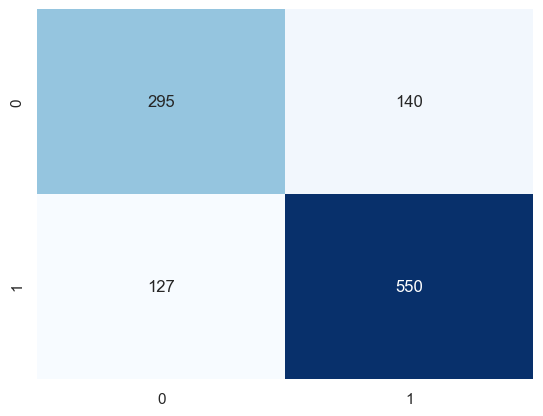

In [91]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues", cbar=False);

In [92]:
#Clearly Overfitted

## 3.9 Gradient Boosting

In [93]:
from sklearn.ensemble import GradientBoostingClassifier

classifier = GradientBoostingClassifier() # base_estimator=DecisionTreeRegressor(max_depth=3)
parameters = {"n_estimators":[20,30], "learning_rate":[ 0.5], 
              "random_state" : [0] ,
             "max_depth":[1,2]}

#Define gridsearch
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1',) 

gs = gs.fit(X_train,y_train)


#summarize the results of gridsearch
print('***GRIDSEARCH RESULTS***')
print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#Returns the coefficient of determination R^2 of the prediction.
#Explained variance score: 1 is perfect prediction
gs.score(X_test, y_test)

***GRIDSEARCH RESULTS***
Best score: 0.787478 using {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 30, 'random_state': 0}
0.775318 (0.009669) with: {'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 20, 'random_state': 0}
0.778081 (0.010761) with: {'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 30, 'random_state': 0}
0.778485 (0.003536) with: {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 20, 'random_state': 0}
0.787478 (0.005529) with: {'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 30, 'random_state': 0}


0.8062455642299503

In [94]:
best_model = gs.best_estimator_

y_pred = best_model.predict(X_test)

y_pred_train = best_model.predict(X_train)

In [95]:
#Evaluate predictions training set

print('***RESULTS ON TRAIN SET***')
print("precision: ", metrics.precision_score(y_train, y_pred_train)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_train, y_pred_train)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_train, y_pred_train)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_train, y_pred_train)) # (tp+tn)/m

#Evaluate predictions test set
from sklearn import metrics 

print('***RESULTS ON TEST SET***')
print("precision: ", metrics.precision_score(y_test, y_pred)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_test, y_pred)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_test, y_pred)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_test, y_pred)) # (tp+tn)/m

***RESULTS ON TRAIN SET***
precision:  0.8060141509433962
recall:  0.8668357641090678
f1_score:  0.8353192789489765
accuracy:  0.7920524691358025
***RESULTS ON TEST SET***
precision:  0.7759562841530054
recall:  0.8389955686853766
f1_score:  0.8062455642299503
accuracy:  0.7544964028776978


In [96]:
#test on the test set
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)

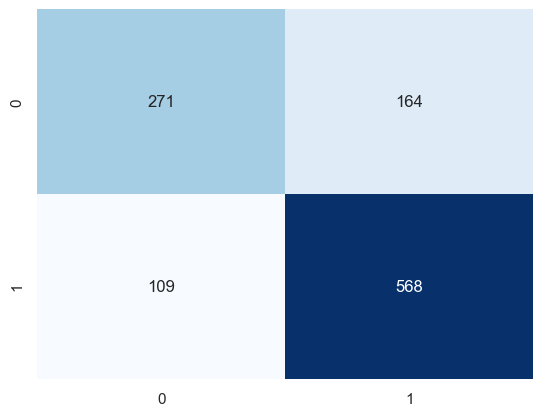

In [97]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues", cbar=False);

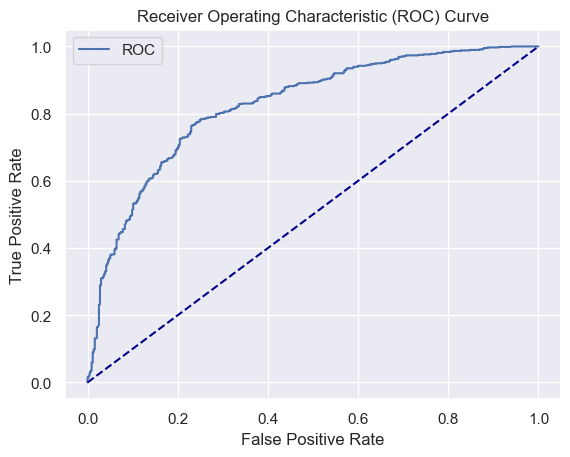

AUC: 0.82


In [98]:
from sklearn import metrics

gboost = GradientBoostingClassifier(learning_rate= 0.5, max_depth= 2, n_estimators= 30)

gboost.fit(X_train,y_train)

y_probs = gboost.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

In [99]:
import pickle
pickle.dump(gboost, open('gboost_model.pkl', 'wb'))

In [100]:
#another contender

# 4.Selecting a model 🐎

### After a careful analysis we picked the best 3 performers models:

### A) Logistic Regression 
### B) Gradient Boosting
### C) SVM

### Our best model for us is Logistic Regression

In [101]:
from sklearn.linear_model import LogisticRegression

#classifier = LogisticRegression()
#parameters = {"C":[1e-2,1e-1,1],"penalty":['l2'] , "max_iter":[50000,10000]}
classifier = LogisticRegression()
#"C":[1e-2,1e-1,10],"penalty":['l2'] , "max_iter":[50000,10000]
# solver : Algorithm to use in the optimization problem{ ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’} #"solver":["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
parameters = {"C":[1e-2,1e-1,1,3,5,10],"penalty":['l2'] , "max_iter":[500,1000], "solver":["newton-cg", "lbfgs", "liblinear"]} #1e-2,





In [102]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'accuracy', verbose=50, n_jobs=-1, refit=True)

In [103]:
#TRAIN YOUR CLASSIFIER
gs = gs.fit(X_train, y_train)
best_model = gs.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/Users/mikey/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [104]:
print('***GRIDSEARCH RESULTS***')
print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.743441 using {'C': 3, 'max_iter': 500, 'penalty': 'l2', 'solver': 'newton-cg'}
0.714120 (0.017502) with: {'C': 0.01, 'max_iter': 500, 'penalty': 'l2', 'solver': 'newton-cg'}
0.714120 (0.017502) with: {'C': 0.01, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
0.714506 (0.017485) with: {'C': 0.01, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
0.714120 (0.017502) with: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.714120 (0.017502) with: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.714506 (0.017485) with: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
0.739198 (0.015595) with: {'C': 0.1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'newton-cg'}
0.739198 (0.015595) with: {'C': 0.1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
0.739198 (0.014772) with: {'C': 0.1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
0.739198 (0.015595) with: {'C': 0.1, 'm

In [105]:
#Evaluate training set
y_pred_train = best_model.predict(X_train)
y_pred = best_model.predict(X_test)

print('***RESULTS ON TRAIN SET***')
print("precision: ", metrics.precision_score(y_train, y_pred_train)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_train, y_pred_train)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_train, y_pred_train)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_train, y_pred_train)) # (tp+tn)/m

#Evaluate test set
from sklearn import metrics 

print('***RESULTS ON TEST SET***')
print("precision: ", metrics.precision_score(y_test, y_pred)) # tp / (tp + fp)
print("recall: ", metrics.recall_score(y_test, y_pred)) # tp / (tp + fn)
print("f1_score: ", metrics.f1_score(y_test, y_pred)) #F1 = 2 * (precision * recall) / (precision + recall)
print("accuracy: ", metrics.accuracy_score(y_test, y_pred)) # (tp+tn)/m

***RESULTS ON TRAIN SET***
precision:  0.815347721822542
recall:  0.8623969562460367
f1_score:  0.8382126348228044
accuracy:  0.7974537037037037
***RESULTS ON TEST SET***
precision:  0.7857142857142857
recall:  0.844903988183161
f1_score:  0.81423487544484
accuracy:  0.7652877697841727


In [106]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.64      0.68       435
           1       0.79      0.84      0.81       677

    accuracy                           0.77      1112
   macro avg       0.76      0.74      0.75      1112
weighted avg       0.76      0.77      0.76      1112



In [107]:
#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[279 156]
 [105 572]]


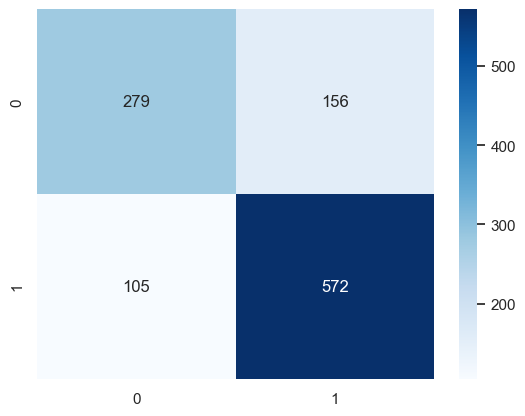

In [108]:
# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues"); #annot=True to annotate cells fmt: format

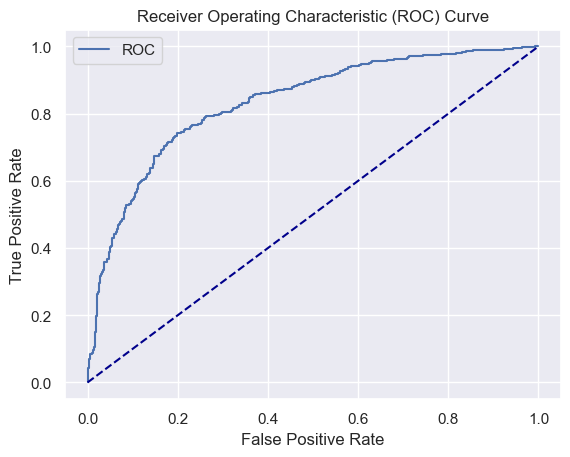

AUC: 0.83


In [109]:
#Plot Roc Curve
from sklearn import metrics

model = LogisticRegression(C=3,solver='newton-cg')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_probs = model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case) 

fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

In [110]:
#Get the coefficients to display the representation of the weights assigned to the input features in order to make predictions. 
best_model.coef_

array([[ 1.14594298e-01,  3.17966370e-02,  5.31823070e-02,
         1.83014147e-01, -2.63714412e-01,  5.80974293e-02,
         2.03329255e-01, -2.90096175e-02, -8.36000271e-02,
         1.14359263e-01, -6.32228032e-02,  2.83489750e-01,
         2.12412036e-01, -2.90958400e-02, -8.43821150e-02,
        -7.86905725e-02,  3.98810381e-01, -1.89254686e-01,
         7.66576391e-03, -1.08384117e-01,  5.43074995e-01,
        -1.91901675e-01,  2.36406523e-01, -1.42699521e-04,
        -9.71329149e-02, -6.03965798e-01,  4.64894503e-01,
         2.73776187e-01, -1.50715105e-01, -2.46656486e-01,
        -1.05769086e-01, -1.72612214e-01,  4.02036318e-01,
        -2.15885472e-01, -9.71766429e-02, -4.41137196e-01,
         7.54258925e-01,  5.43655012e-01, -8.42483543e-01,
        -8.83349344e-01,  4.19384752e-01, -4.85972608e-01,
         7.47426495e-01,  2.59630864e-01,  3.60885456e-01,
        -1.65822996e-01,  2.96737989e-01, -1.39647445e-01,
        -1.10385017e-01, -8.91074222e-01,  3.36089869e-0

In [111]:
#Create a list  to interpret the impact of each feature on the target variable.
list(zip(X_train.columns, best_model.coef_[0,:]))

[('Days', 0.11459429820559609),
 ('CRM_Segment', 0.03179663701139941),
 ('SPR_New_Existing', 0.053182307020267154),
 ('NumberOfMeetingswithParents', 0.18301414715482686),
 ('DifferenceTraveltoFirstMeeting', -0.2637144124246391),
 ('DifferenceTraveltoLastMeeting', 0.05809742927559664),
 ('Tuition', 0.2033292552355941),
 ('FRP_Take_up_percent_', -0.029009617465550436),
 ('FPP_to_PAX', -0.08360002707057253),
 ('NtripOrganizationDays', 0.11435926299908117),
 ('NDaysLastAdviceToDeparture', -0.06322280317462414),
 ('NDaysFromDepositeToDeparture', 0.2834897504102888),
 ('Log_Total_School_Enrollment', 0.2124120363718344),
 ('Log_Cancelled_Pax', -0.029095839981555793),
 ('Log_Total_Discount_Pax', -0.08438211500838762),
 ('Log_FPP', -0.07869057247631168),
 ('Log_FRP_Active', 0.3988103812048109),
 ('Log_FRP_Cancelled', -0.18925468565741202),
 ('Log_EZ_Pay_Take_Up_Rate', 0.0076657639137162675),
 ('Log_Num_of_Non_FPP_PAX', -0.10838411744334954),
 ('Log_Total_Pax', 0.5430749949776215),
 ('Log_SPR_Gr

<AxesSubplot:>

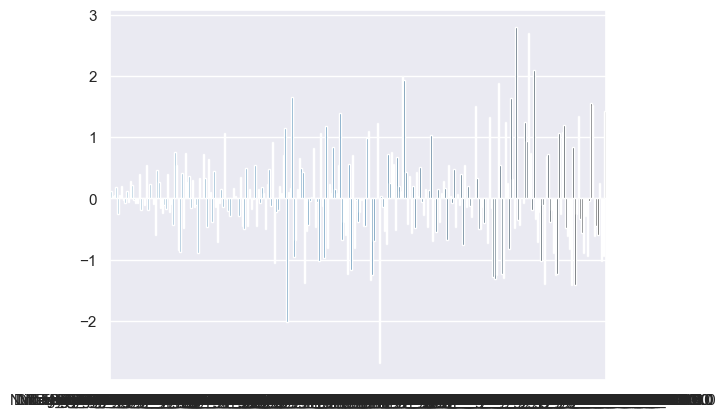

In [112]:
sns.barplot(x=X_train.columns, y=best_model.coef_[0,:], palette="Blues_d")

In [113]:
# Extract the coefficients of the features of the logistic regression model into a dataframe
best_model.fit(X_train,y_train)

coeff=pd.DataFrame()
coeff["feature"]=X_train.columns
coeff["w"]=best_model.coef_[0]

coeff.sort_values(by=['w'], inplace=True)


In [114]:
#Plot the results
sns.set(rc={'figure.figsize':(100,100)})
sns.barplot(data=coeff, y="feature", x="w", palette="Blues_d", orient="h")
sns.set(rc={'figure.figsize':(6,4)})

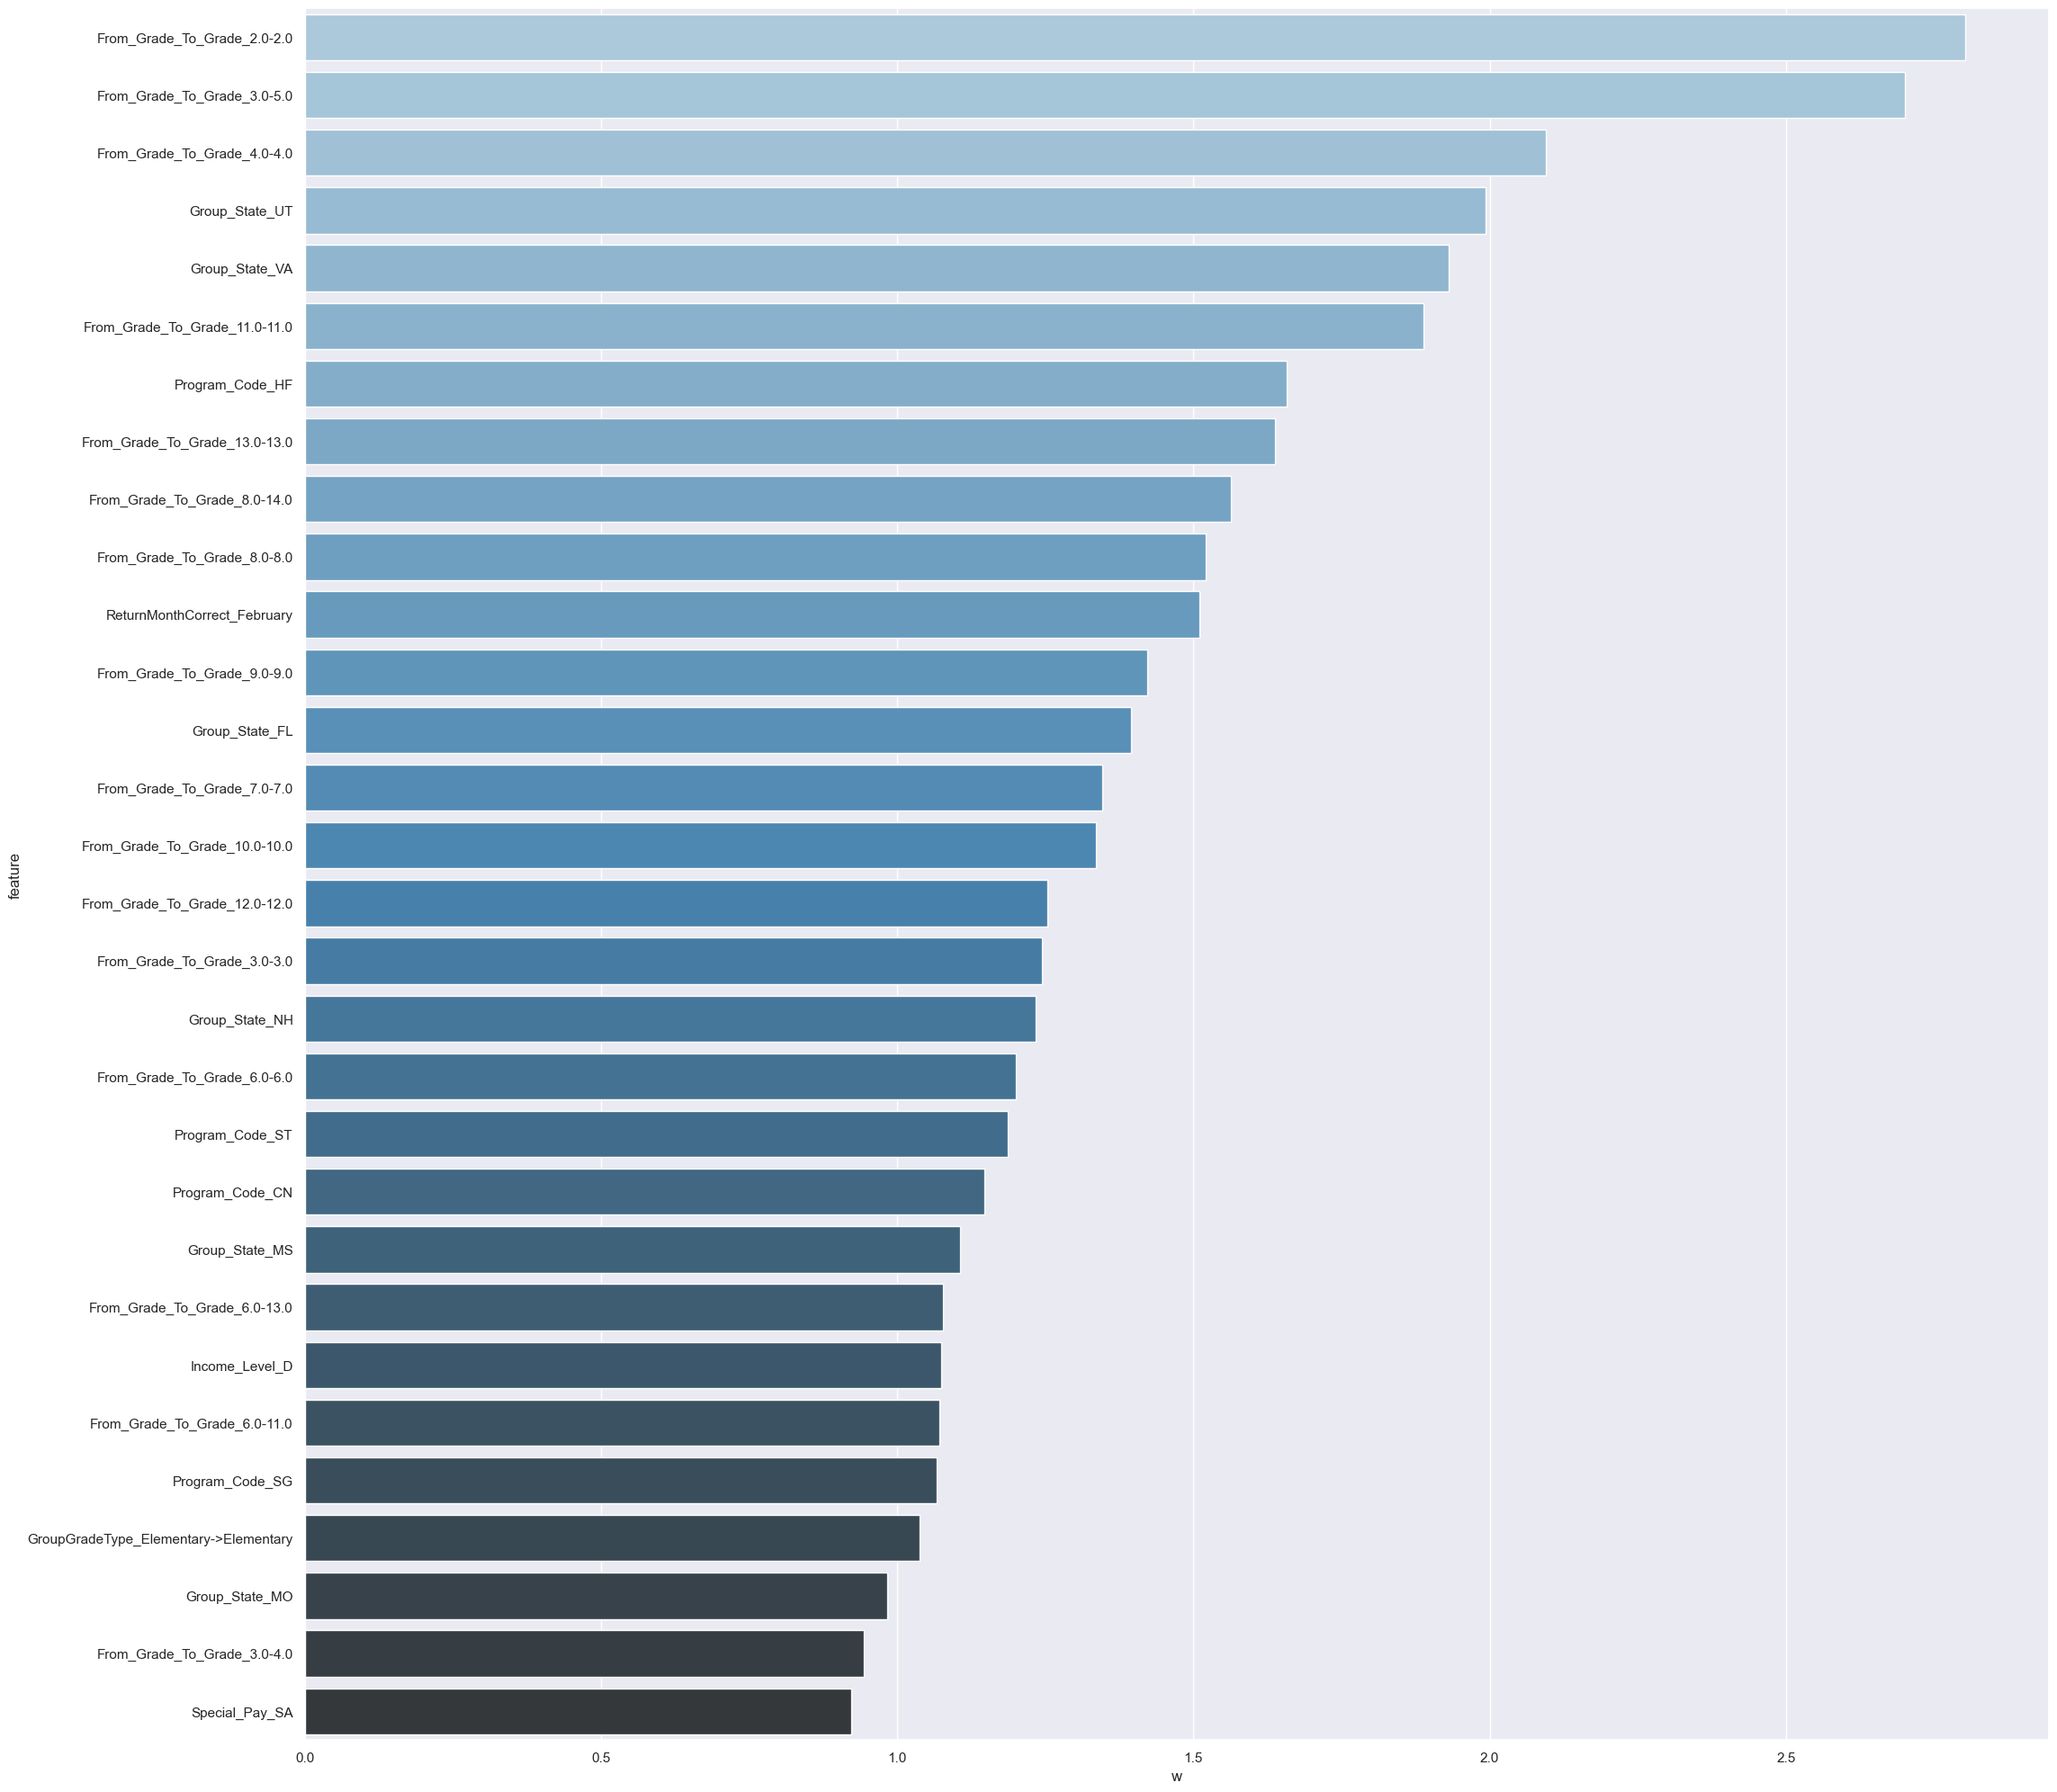

In [115]:
import seaborn as sns

# Plot the results
sns.set(rc={'figure.figsize':(25,25)})
sns.barplot(data=coeff.nlargest(30, 'w'), y="feature", x="w", palette="Blues_d", orient="h")
sns.set(rc={'figure.figsize':(6,4)})

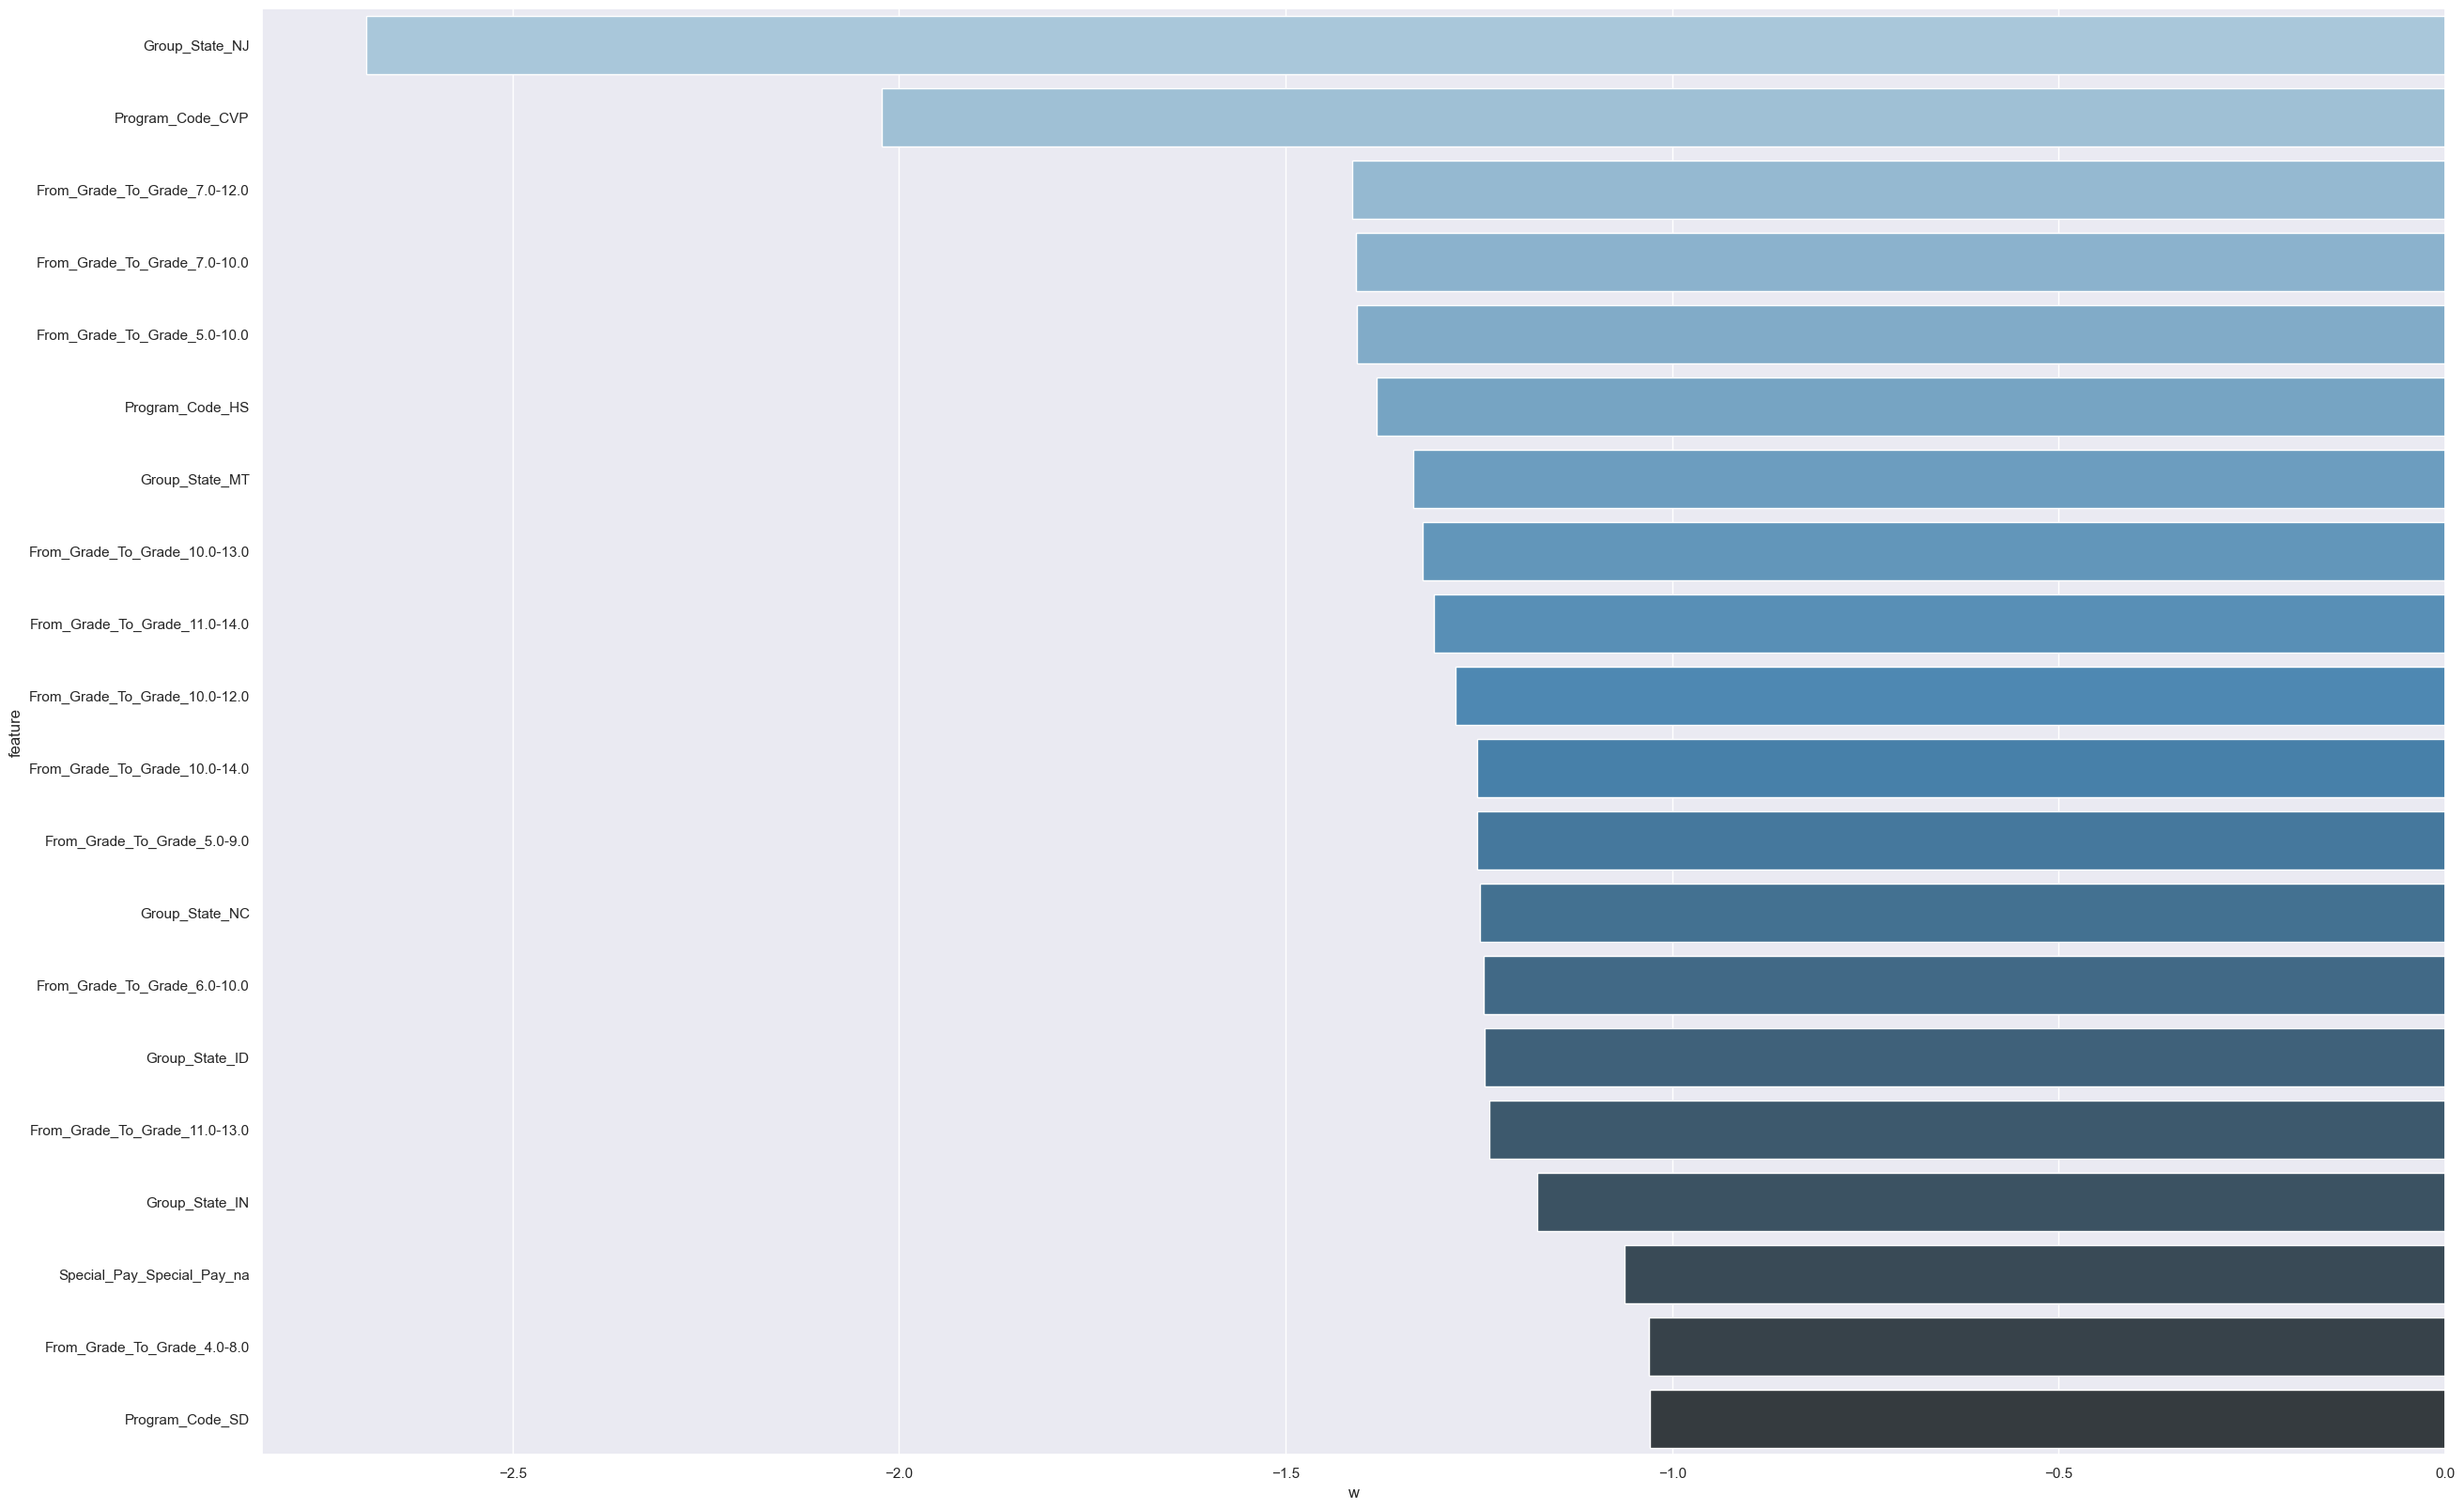

In [116]:
import seaborn as sns

# Plot the results
sns.set(rc={'figure.figsize':(30,20)})
sns.barplot(data=coeff.nsmallest(20, 'w'), y="feature", x="w", palette="Blues_d", orient="h")
sns.set(rc={'figure.figsize':(6,4)})

In [117]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [120]:
#save the model
LogReg = LogisticRegression(C=3, max_iter=500, penalty='l2', solver='newton-cg')
LogReg.fit(X,y)


LogisticRegression(C=3, max_iter=500, solver='newton-cg')

In [121]:
import pickle
pickle.dump(LogReg, open('LogReg_model.pkl', 'wb'))

# 5. Cleaning & Merging unlabeled datasets 🧹

## Import Unlabeled data

In [122]:
#Import datasets
crm_test = pd.read_csv("/Users/mikey/Desktop/ML project /unlabeled_data/crm_test.csv")
finance_test = pd.read_csv("/Users/mikey/Desktop/ML project /unlabeled_data/finance_test.csv")
sales_test = pd.read_csv("/Users/mikey/Desktop/ML project /unlabeled_data/sales_test.csv")


## Preparing Datasets for the merge

In [123]:
# convert columns ID_SALES, Program_Code and Travel_Type to strings
sales_test['ID_SALES'] = sales_test['ID_SALES'].astype(str)
sales_test['Program_Code'] = sales_test['Program_Code'].astype(str)
sales_test['Travel_Type'] = sales_test['Travel_Type'].astype(str)
# remove initial and final parts based on columns Program_Code and Travel_Type
sales_test["NEW_ID_SALES"] = sales_test.apply(lambda row: row["ID_SALES"][len(row['Program_Code']):], axis=1)
sales_test["NEW_ID_SALES"] = sales_test.apply(lambda row: row["NEW_ID_SALES"][:-len(row['Travel_Type'])] if row['Travel_Type'] != 'N/A' else row['Clean_ID'], axis=1)

print(sales_test.shape)
# convert columns ID_FINANCE and Special_Pay to strings
finance_test['ID_FINANCE'] = finance_test['ID_FINANCE'].astype(str)
finance_test['Special_Pay'] = finance_test['Special_Pay'].astype(str)

# remove initial and final parts based on column Special Pay
#finance["NEW_ID_FINANCE"] = finance.apply(lambda row: row['NEW_ID_FINANCE'][len(row['Special_Pay']):] if row['Special_Pay'] != '0' else row['ID_FINANCE'], axis=1)
finance_test["NEW_ID_FINANCE"] = finance_test["ID_FINANCE"].str.extract('(\d+)', expand=False)
print(finance_test.shape)

# convert columns ID_CRM, Poverty_Code and Income_Level to strings
crm_test['ID_CRM'] = crm_test['ID_CRM'].astype(str)
crm_test['Poverty_Code'] = crm_test['Poverty_Code'].astype(str)
crm_test['Income_Level'] = crm_test['Income_Level'].astype(str)

# remove initial and final parts based on columns B and Travel_Type
crm_test['NEW_ID_CRM'] = crm_test.apply(lambda row: row['ID_CRM'][len(row['Poverty_Code']):], axis=1)
crm_test['NEW_ID_CRM'] = crm_test.apply(lambda row: row['NEW_ID_CRM'][:-len(row['Income_Level'])] if row['Income_Level'] != 'N/A' else row['Clean_ID'], axis=1)
print(crm_test.shape)

(630, 25)
(630, 13)
(630, 21)


## Merging Datasets

In [124]:
#Merging Datasets
merge1_test=pd.merge(sales_test,crm_test,left_on="NEW_ID_SALES",right_on="NEW_ID_CRM" )
merge2_test=pd.merge(merge1_test,finance_test,left_on="NEW_ID_SALES",right_on="NEW_ID_FINANCE" )
merge2_test.info()
print(merge1_test.shape)
print(merge2_test.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 630 entries, 0 to 629
Data columns (total 59 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID_SALES                        630 non-null    object 
 1   Program_Code                    630 non-null    object 
 2   From_Grade                      602 non-null    float64
 3   To_Grade                        599 non-null    float64
 4   Group_State                     630 non-null    object 
 5   Days                            630 non-null    int64  
 6   Travel_Type                     630 non-null    object 
 7   Departure_Date                  630 non-null    object 
 8   Return_Date                     630 non-null    object 
 9   Early_RPL                       451 non-null    object 
 10  Latest_RPL                      628 non-null    object 
 11  Cancelled_Pax                   630 non-null    int64  
 12  Total_Discount_Pax              630 

## Data Cleaning

In [125]:
#Drop the column, too many missing values
datacleaning_1_test=merge2_test.drop(["Early_RPL","Unnamed: 23"],axis=1)
#drop all the old Id
datacleaning_1_test=datacleaning_1_test.drop("ID_CRM",axis=1)
datacleaning_1_test=datacleaning_1_test.drop("ID_FINANCE",axis=1)
datacleaning_1_test=datacleaning_1_test.drop("ID_SALES",axis=1)
#transformation in order to don't have the category NA as a missing value and convert 0 to na
datacleaning_1_test[['Special_Pay']] =datacleaning_1_test[['Special_Pay']].fillna('Special_Pay_na')
datacleaning_1_test[['Special_Pay']] =datacleaning_1_test[['Special_Pay']].replace({'0':'Special_Pay_na'})
#Cleanin From To Grade
datacleaning_1_test["From_Grade"].fillna(datacleaning_1_test["From_Grade"].mode()[0], inplace=True)
datacleaning_1_test["To_Grade"].fillna(datacleaning_1_test["To_Grade"].mode()[0], inplace=True)
datacleaning_1_test['From_Grade_To_Grade'] = datacleaning_1_test['From_Grade'].astype(str) + "-" + datacleaning_1_test['To_Grade'].astype(str)
datacleaning_1_test=datacleaning_1_test.drop("From_Grade",axis=1)
datacleaning_1_test=datacleaning_1_test.drop("To_Grade",axis=1)
#drop column date of firstMeeting and LastMeeting
data_best_test=datacleaning_1_test.drop('FirstMeeting', axis=1)
data_best_test=data_best_test.drop('LastMeeting', axis=1)

In [126]:
#substitute missing data of DifferenceTraveltoFirstMeeting and DifferenceTraveltoLastMeeting with 0 because there was not the meeting 
values = {"DifferenceTraveltoFirstMeeting": 0, "DifferenceTraveltoLastMeeting": 0} 
data_best_test=data_best_test.fillna(value=values)
data_best_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 630 entries, 0 to 629
Data columns (total 51 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Program_Code                    630 non-null    object 
 1   Group_State                     630 non-null    object 
 2   Days                            630 non-null    int64  
 3   Travel_Type                     630 non-null    object 
 4   Departure_Date                  630 non-null    object 
 5   Return_Date                     630 non-null    object 
 6   Latest_RPL                      628 non-null    object 
 7   Cancelled_Pax                   630 non-null    int64  
 8   Total_Discount_Pax              630 non-null    int64  
 9   Initial_System_Date             630 non-null    object 
 10  SPR_Product_Type                630 non-null    object 
 11  FPP                             630 non-null    int64  
 12  Total_Pax                       630 

In [127]:
#Transformation of dates in numerical variables

from datetime import datetime

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%m/%d/%Y")
    d2 = datetime.strptime(d2, "%m/%d/%Y")
    return abs((d2 - d1).days)

data_best_2_test=data_best_test
#data_best_2_test=data_best_test.dropna(subset=["Initial_System_Date"])
data_best_2_test["NtripOrganizationDays"] = data_best_2_test.apply(lambda x: days_between(x["Initial_System_Date"], x["Departure_Date"]), axis=1)

data_best_3_test=data_best_2_test
#data_best_3_test=data_best_2_test.dropna(subset=["Latest_RPL"])
data_best_3_test[["Latest_RPL"]] = data_best_2_test[["Latest_RPL"]].fillna('12/12/2050')
data_best_3_test["NDaysLastAdviceToDeparture"] = data_best_3_test.apply(lambda x: days_between(x["Latest_RPL"], x["Departure_Date"]), axis=1)
data_best_3_test.loc[data_best_3_test["NDaysLastAdviceToDeparture"] > 1000, "NDaysLastAdviceToDeparture"] = 0
#I do this trick of putting a date which gives me a high number in number of days and then I replace the high number with 0
#unique_values = data_best_3_test["NDaysLastAdviceToDeparture"].unique()
#print(unique_values)

data_best_4_test=data_best_3_test
#data_best_4_test=data_best_3_test.dropna(subset=["Deposit_Date"])
data_best_4_test["NDaysFromDepositeToDeparture"] = data_best_4_test.apply(lambda x: days_between(x["Deposit_Date"], x["Departure_Date"]), axis=1)

#it is strange that in category month we only have january and february...so we decided to extract the month form the departure date and also to extract the month of the return date
def extract_month(d1):
    d1 = datetime.strptime(d1, "%m/%d/%Y")
    return (d1).month
data_best_4_test["DepartureMonthCorrect"] = data_best_4_test.apply(lambda x: extract_month(x["Departure_Date"]), axis=1)
data_best_4_test["ReturnMonthCorrect"] = data_best_4_test.apply(lambda x: extract_month(x["Return_Date"]), axis=1)
data_best_4_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 630 entries, 0 to 629
Data columns (total 56 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Program_Code                    630 non-null    object 
 1   Group_State                     630 non-null    object 
 2   Days                            630 non-null    int64  
 3   Travel_Type                     630 non-null    object 
 4   Departure_Date                  630 non-null    object 
 5   Return_Date                     630 non-null    object 
 6   Latest_RPL                      630 non-null    object 
 7   Cancelled_Pax                   630 non-null    int64  
 8   Total_Discount_Pax              630 non-null    int64  
 9   Initial_System_Date             630 non-null    object 
 10  SPR_Product_Type                630 non-null    object 
 11  FPP                             630 non-null    int64  
 12  Total_Pax                       630 

In [128]:
import datetime
# Create a list of the month names
month_names = [datetime.date(1900, i, 1).strftime('%B') for i in range(1, 13)]

# Replace the numbers with the month names
data_best_4_test["DepartureMonthCorrect"] = data_best_4_test["DepartureMonthCorrect"] .replace(range(1, 13), month_names)
data_best_4_test["ReturnMonthCorrect"] = data_best_4_test["ReturnMonthCorrect"] .replace(range(1, 13), month_names)


#drop NA values
#data_best_5_test=data_best_4_test.dropna(subset=["MDR_High_Grade","From_Grade", "To_Grade", "FPP_to_School_enrollment", "SchoolSizeIndicator", "CRM_Segment"])
data_best_5_test=data_best_4_test
data_best_5_test["MDR_High_Grade"].fillna(data_best_5_test["MDR_High_Grade"].mode()[0], inplace=True)
data_best_5_test["FPP_to_School_enrollment"].fillna(data_best_5_test["FPP_to_School_enrollment"].median(), inplace=True)
data_best_5_test["SchoolSizeIndicator"].fillna(data_best_5_test["SchoolSizeIndicator"].mode()[0], inplace=True)
data_best_5_test["CRM_Segment"].fillna(data_best_5_test["CRM_Segment"].mode()[0], inplace=True)

#drop NewIDs
byebyeID=["NEW_ID_CRM", "NEW_ID_FINANCE", "NEW_ID_SALES"]
data_best_5_test=data_best_5_test.drop(byebyeID, axis=1)


#drop columns with redundant information
todrop2=["Parent_Meeting_Flag", 'SchoolGradeTypeLow', 'SchoolGradeTypeHigh', 'GroupGradeTypeLow', 'GroupGradeTypeHigh']
data_best_5_test=data_best_5_test.drop(todrop2, axis=1)

#drop dates
todrop=["Return_Date", "Departure_Date", "Initial_System_Date", "Latest_RPL", "Deposit_Date", "DepartureMonth"]
data_best_final_test=data_best_5_test.drop(todrop, axis=1)

data_best_final_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 630 entries, 0 to 629
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Program_Code                    630 non-null    object 
 1   Group_State                     630 non-null    object 
 2   Days                            630 non-null    int64  
 3   Travel_Type                     630 non-null    object 
 4   Cancelled_Pax                   630 non-null    int64  
 5   Total_Discount_Pax              630 non-null    int64  
 6   SPR_Product_Type                630 non-null    object 
 7   FPP                             630 non-null    int64  
 8   Total_Pax                       630 non-null    int64  
 9   GroupGradeType                  630 non-null    object 
 10  MajorProgramCode                630 non-null    object 
 11  FPP_to_School_enrollment        630 non-null    float64
 12  Poverty_Code                    630 

In [129]:
#Fixing data types
df_test=data_best_final_test
df_test['FRP_Take_up_percent_'] = df_test['FRP_Take_up_percent_'].astype(str)
df_test['EZ_Pay_Take_Up_Rate'] = df_test['EZ_Pay_Take_Up_Rate'].astype(str)
df_test['FPP_to_School_enrollment'] = df_test['FPP_to_School_enrollment'].astype(str)
df_test['FPP_to_PAX'] = df_test['FPP_to_PAX'].astype(str)
df_test['FRP_Take_up_percent_'] = df_test['FRP_Take_up_percent_'].str.replace(',', '.').astype(float)
df_test['EZ_Pay_Take_Up_Rate'] = df_test['EZ_Pay_Take_Up_Rate'].str.replace(',', '.').astype(float)
df_test['FPP_to_School_enrollment'] = df_test['FPP_to_School_enrollment'].str.replace(',', '.').astype(float)
df_test['FPP_to_PAX'] = df_test['FPP_to_PAX'].str.replace(',', '.').astype(float)

In [130]:
#'From_Grade' 'To_Grade''MDR_High_Grade' 
df_test['MDR_High_Grade' ] = df_test['MDR_High_Grade'].astype(object)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 630 entries, 0 to 629
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Program_Code                    630 non-null    object 
 1   Group_State                     630 non-null    object 
 2   Days                            630 non-null    int64  
 3   Travel_Type                     630 non-null    object 
 4   Cancelled_Pax                   630 non-null    int64  
 5   Total_Discount_Pax              630 non-null    int64  
 6   SPR_Product_Type                630 non-null    object 
 7   FPP                             630 non-null    int64  
 8   Total_Pax                       630 non-null    int64  
 9   GroupGradeType                  630 non-null    object 
 10  MajorProgramCode                630 non-null    object 
 11  FPP_to_School_enrollment        630 non-null    float64
 12  Poverty_Code                    630 

In [131]:
#We replace string 0 with string A because poverty code is A if the value is between 0 and 5.9
df_test["Poverty_Code"] = df_test["Poverty_Code"].replace({'0': 'A'})
#We replace string P+number with string P
df_test["Income_Level"] = df_test["Income_Level"].replace({'P3': 'P'}, regex=True)
df_test["Income_Level"] = df_test["Income_Level"].replace({'P4': 'P'})
df_test["Income_Level"] = df_test["Income_Level"].replace({'P1': 'P'})

In [132]:
#'From_Grade' 'To_Grade''MDR_High_Grade' 
df_test['MDR_High_Grade' ] = df_test['MDR_High_Grade'].astype(object)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 630 entries, 0 to 629
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Program_Code                    630 non-null    object 
 1   Group_State                     630 non-null    object 
 2   Days                            630 non-null    int64  
 3   Travel_Type                     630 non-null    object 
 4   Cancelled_Pax                   630 non-null    int64  
 5   Total_Discount_Pax              630 non-null    int64  
 6   SPR_Product_Type                630 non-null    object 
 7   FPP                             630 non-null    int64  
 8   Total_Pax                       630 non-null    int64  
 9   GroupGradeType                  630 non-null    object 
 10  MajorProgramCode                630 non-null    object 
 11  FPP_to_School_enrollment        630 non-null    float64
 12  Poverty_Code                    630 

In [133]:
#Loading the model
loaded_encoder = pickle.load(open('encoder.pkl', 'rb')) #load preprocesing 
loaded_scaler = pickle.load(open('scaler.pkl', 'rb')) #load preprocesing

In [134]:
#Categorical
#We obtain the dummies for the unlabeled dataset
columns_cat = ['Poverty_Code', 'Region', 'School_Type', 'MDR_Low_Grade','MDR_High_Grade', 'Income_Level', 
           'SchoolGradeType', 'SchoolSizeIndicator', 'Special_Pay','School_Sponsor','Program_Code', 
           'Group_State', 'Travel_Type', 'SPR_Product_Type', 'GroupGradeType', 'MajorProgramCode', 
           'DepartureMonthCorrect','ReturnMonthCorrect','From_Grade_To_Grade']

dummies_unlabeled_test = loaded_encoder.transform(df_test[columns_cat]).toarray()
columns_dummies=loaded_encoder.get_feature_names_out()
dummies_unlabeled_test = pd.DataFrame(dummies_unlabeled_test,columns=columns_dummies)






In [135]:
#Numerical
columns = ['Poverty_Code', 'Region', 'School_Type', 'MDR_Low_Grade','MDR_High_Grade', 'Income_Level', 
           'SchoolGradeType', 'SchoolSizeIndicator', 'Special_Pay','School_Sponsor','Program_Code', 
           'Group_State', 'Travel_Type', 'SPR_Product_Type', 'GroupGradeType', 'MajorProgramCode', 
           'DepartureMonthCorrect','ReturnMonthCorrect','MDR_High_Grade', 'From_Grade_To_Grade']  #'From_Grade', 'To_Grade'
df_num_test=df_test.drop(columns=columns)



#I transform some numerical variables
df_num_test[["Log_Total_School_Enrollment","Log_Cancelled_Pax", "Log_Total_Discount_Pax", "Log_FPP","FPP_to_School_enrollment", 
             "Log_FRP_Active",
             "Log_FRP_Cancelled","Log_EZ_Pay_Take_Up_Rate",'Log_Num_of_Non_FPP_PAX', 'Log_Total_Pax',
             'Log_SPR_Group_Revenue']] = df_num_test[["Total_School_Enrollment", "Cancelled_Pax", "Total_Discount_Pax",
                                                      "FPP","FPP_to_School_enrollment", "FRP_Active","FRP_Cancelled",
                                                      "EZ_Pay_Take_Up_Rate",'Num_of_Non_FPP_PAX', 'Total_Pax', 
                                                      'SPR_Group_Revenue']].apply(lambda x: np.log(x+1))

df_num_test=df_num_test.drop(["Total_School_Enrollment", "Cancelled_Pax", "Total_Discount_Pax",
                              "FPP","FPP_to_School_enrollment", "FRP_Active","FRP_Cancelled",
                              "EZ_Pay_Take_Up_Rate",'Num_of_Non_FPP_PAX', 'Total_Pax', 
                              'SPR_Group_Revenue'], axis=1)
#df_num_test.info()
#scaling
df_num_scaled_test = pd.DataFrame(loaded_scaler.transform(df_num_test))

df_num_scaled_test .columns = df_num_test.columns
df_num_scaled_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Days                            630 non-null    float64
 1   CRM_Segment                     630 non-null    float64
 2   SPR_New_Existing                630 non-null    float64
 3   NumberOfMeetingswithParents     630 non-null    float64
 4   DifferenceTraveltoFirstMeeting  630 non-null    float64
 5   DifferenceTraveltoLastMeeting   630 non-null    float64
 6   Tuition                         630 non-null    float64
 7   FRP_Take_up_percent_            630 non-null    float64
 8   FPP_to_PAX                      630 non-null    float64
 9   NtripOrganizationDays           630 non-null    float64
 10  NDaysLastAdviceToDeparture      630 non-null    float64
 11  NDaysFromDepositeToDeparture    630 non-null    float64
 12  Log_Total_School_Enrollment     630 

In [136]:
#Concatenating the dataframes
df_conc_test=pd.concat([df_num_scaled_test, dummies_unlabeled_test], axis=1)
df_conc_test.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 279 columns):
 #    Column                                  Dtype  
---   ------                                  -----  
 0    Days                                    float64
 1    CRM_Segment                             float64
 2    SPR_New_Existing                        float64
 3    NumberOfMeetingswithParents             float64
 4    DifferenceTraveltoFirstMeeting          float64
 5    DifferenceTraveltoLastMeeting           float64
 6    Tuition                                 float64
 7    FRP_Take_up_percent_                    float64
 8    FPP_to_PAX                              float64
 9    NtripOrganizationDays                   float64
 10   NDaysLastAdviceToDeparture              float64
 11   NDaysFromDepositeToDeparture            float64
 12   Log_Total_School_Enrollment             float64
 13   Log_Cancelled_Pax                       float64
 14   Log_Total_Discount_Pax  

# 6. Running the models and displaying predictions 🤖

### We decide to test our top 3 conteders to see how their perfom in the unlabeled dataset

## 🥇 Logistic Regression

In [137]:
# load model 
loaded_model = pickle.load(open('LogReg_model.pkl', 'rb'))



y_output=loaded_model.predict(df_conc_test)

In [138]:
#Display the predictions as an array
y_output

array([1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,

In [139]:
import pandas as pd

# Load the dataset
df_WithPredctions = df_test


# Convert predictions to a DataFrame
predictions_df = pd.DataFrame({'predictions': y_output})

# Concatenate the original dataset and the predictions
result_df = pd.concat([df_WithPredctions, predictions_df], axis=1)

# Display the result

#result_df.head()

#result_df.to_csv('/content/drive/MyDrive/ML_POLIMI/FinalPredictions.csv', index=False)


In [140]:
#import pandas as pd

#path = "/content/drive/MyDrive/ML_POLIMI/Predictions.csv"  # Replace with your desired path
#result_df.to_csv(path, index=False)

In [141]:
#Displaying results
count0_LR=0
count1_LR=0
for element in y_output:
    if element==0:
        count0_LR=count0_LR+1
    elif element==1:
        count1_LR=count1_LR+1
print("number of no-retained customers: "+ str(count0_LR)+" while number of retained customers: "+str(count1_LR))

number of no-retained customers: 254 while number of retained customers: 376


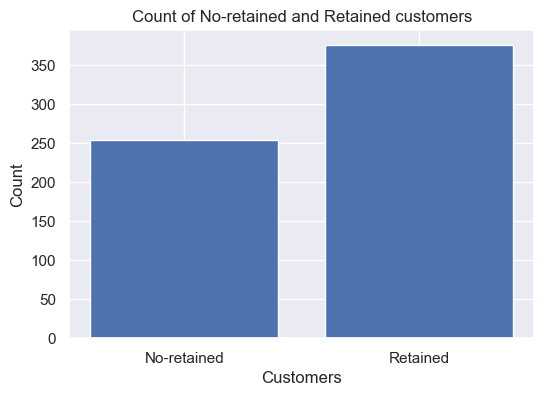

In [142]:
#Plotting results
import matplotlib.pyplot as plt

labels = ['No-retained', 'Retained']
values = [count0_LR, count1_LR]

plt.bar(labels, values)
plt.title('Count of No-retained and Retained customers')
plt.xlabel('Customers')
plt.ylabel('Count')
plt.show()

## 🥈 Gradient Boosting

In [143]:
# load model
loaded_model_2 = pickle.load(open('gboost_model.pkl', 'rb'))



y_output_2=loaded_model_2.predict(df_conc_test)

In [144]:
y_output_2

array([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,

In [145]:
count0_GB=0
count1_GB=0
for element in y_output_2:
    if element==0:
        count0_GB=count0_GB+1
    elif element==1:
        count1_GB=count1_LR+1
print("number of no-retained customers: "+ str(count0_GB)+" while number of retained customers: "+str(count1_GB))

number of no-retained customers: 220 while number of retained customers: 377


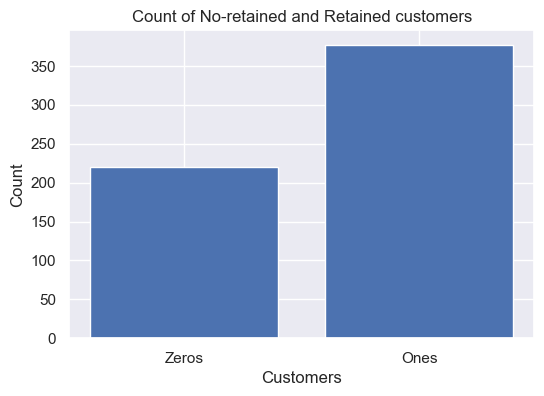

In [146]:
import matplotlib.pyplot as plt

labels = ['Zeros', 'Ones']
values = [count0_GB, count1_GB]

plt.bar(labels, values)
plt.title('Count of No-retained and Retained customers')
plt.xlabel('Customers')
plt.ylabel('Count')
plt.show()

## 🥉 SVM

In [147]:
# load model
loaded_model_3 = pickle.load(open('SupportVC_model.pkl', 'rb'))



y_output_3=loaded_model_3.predict(df_conc_test)

In [148]:
y_output_3

array([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,

In [149]:
count0_SVC=0
count1_SVC=0
for element in y_output_3:
    if element==0:
        count0_SVC=count0_SVC+1
    elif element==1:
        count1_SVC=count1_SVC+1
print("number of no-retained customers: "+ str(count0_SVC)+" while number of retained customers: "+str(count1_SVC))

number of no-retained customers: 266 while number of retained customers: 364
